**UNIVERSIDADE DE SÃO PAULO**<br>
**MBA DATA SCIENCE & ANALYTICS USP/ESALQ**<br>
**SÉRIES TEMPORAIS**<br>
**Prof. Fabiano Guasti Lima**<br>
Aluna: Luiza Batista Laquini<br>
Turma: DSA 241<br>

*coding: utf-8*

In [15]:
# Importando bibliotecas

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import yfinance as yf
import statsmodels.api as sm
import ipeadatapy as ip

from pandas.plotting import register_matplotlib_converters

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error as mape

from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.tsa.api import SimpleExpSmoothing, Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from scipy.stats import shapiro, kstest
#from pmdarima import auto_arima
from bcb import sgs
from arch import arch_model

import warnings

# Capturar avisos de convergência e tratá-los
warnings.filterwarnings("error", category=ConvergenceWarning)

### base PETR4

In [26]:
# In[1]: 
###############################################################################
### Trabalhando com a base de dados de ações da Petrobras (PETR4)
###############################################################################

# Lendo a base de dados
basepetr4 = pd.read_excel("data/basepetr4.xlsx")

# Exibindo apenas as primeiras linhas das variaveis
basepetr4.head()

,Date,abertura,maxima,minimo,fechamento,volume
0,2020-01-02 16:56:00,30.51,30.70,30.31,30.70,37774500
1,2020-01-03 00:00:00,30.88,31.24,30.45,30.45,71595600
2,2020-01-07 16:56:00,30.82,30.88,30.47,30.69,32822000
3,2020-01-08 16:56:00,30.69,30.77,30.24,30.50,48215600
4,2020-01-09 16:56:00,30.47,30.62,30.25,30.40,36102700


In [27]:
# Buscando a cotacoes de fechamento apenas da PETR4 e chamando os dados em petr4
petr4 = basepetr4['fechamento']

petr4.head()

0    30.70
1    30.45
2    30.69
3    30.50
4    30.40
Name: fechamento, dtype: float64

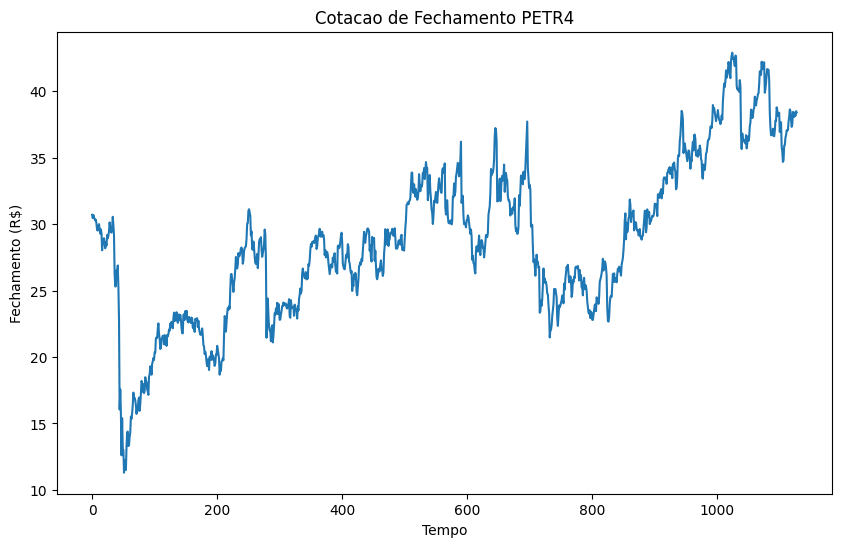

In [28]:
# In[2]: Plotando o grafico bruto
plt.figure(figsize=(10, 6))
plt.plot(petr4)
plt.title('Cotacao de Fechamento PETR4')
plt.xlabel('Tempo')
plt.ylabel('Fechamento (R$)')
plt.show()

In [29]:
# In[3]: Definindo petr4 como uma serie temporal
petr4_ts = pd.Series(petr4.values, index=pd.to_datetime(basepetr4['Date']))

# Quantas cotacoes tenho?
print(len(petr4_ts))

1128


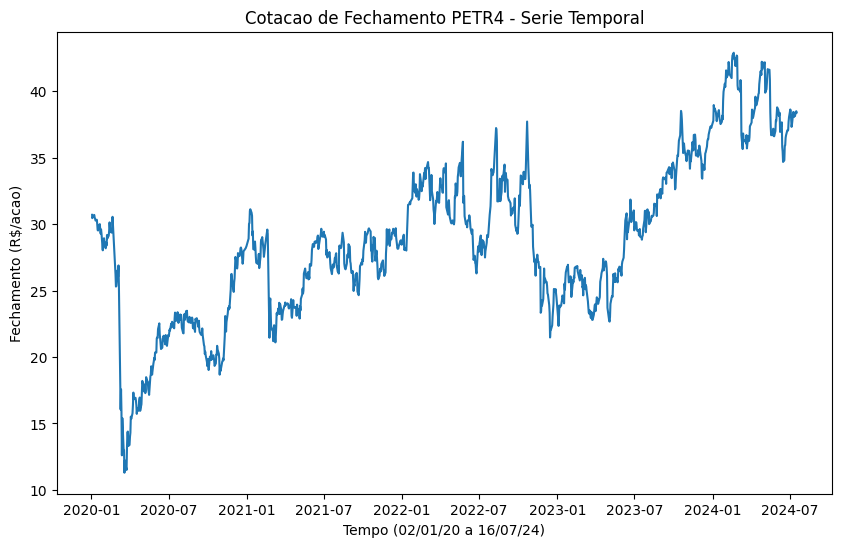

In [30]:
# In[4]: Grafico como serie de tempo usando Plotly 
plt.figure(figsize=(10, 6))
plt.plot(petr4_ts)
plt.title('Cotacao de Fechamento PETR4 - Serie Temporal')
plt.xlabel('Tempo (02/01/20 a 16/07/24)')
plt.ylabel('Fechamento (R$/acao)')
plt.show()

In [38]:
# In[5]: Considerando as demais informacoes da base de dados basepetr4
volume = basepetr4['volume']
minimo = basepetr4['minimo']
abertura = basepetr4['abertura']

# In[6]: Colocando os dados em forma de uma matriz com todos os dados no conjunto
# chamado dados1
dados1 = pd.concat([petr4, volume, minimo, abertura], axis=1)
dados1.columns = ['Fechamento R$', 'Volume Financ. Neg', 'Minimo R$', 
                  'Abertura R$']

# # In[7]: Plotando os graficos
# plt.figure(figsize=(10, 6))
# plt.plot(dados1['Volume Financ. Neg'])
# plt.title('Volume Negociado da PETR4 - jan/2020 a jul/2024')
# plt.xlabel('Tempo (02/01/20 a 16/07/24)')
# plt.ylabel('Volume')
# plt.show()

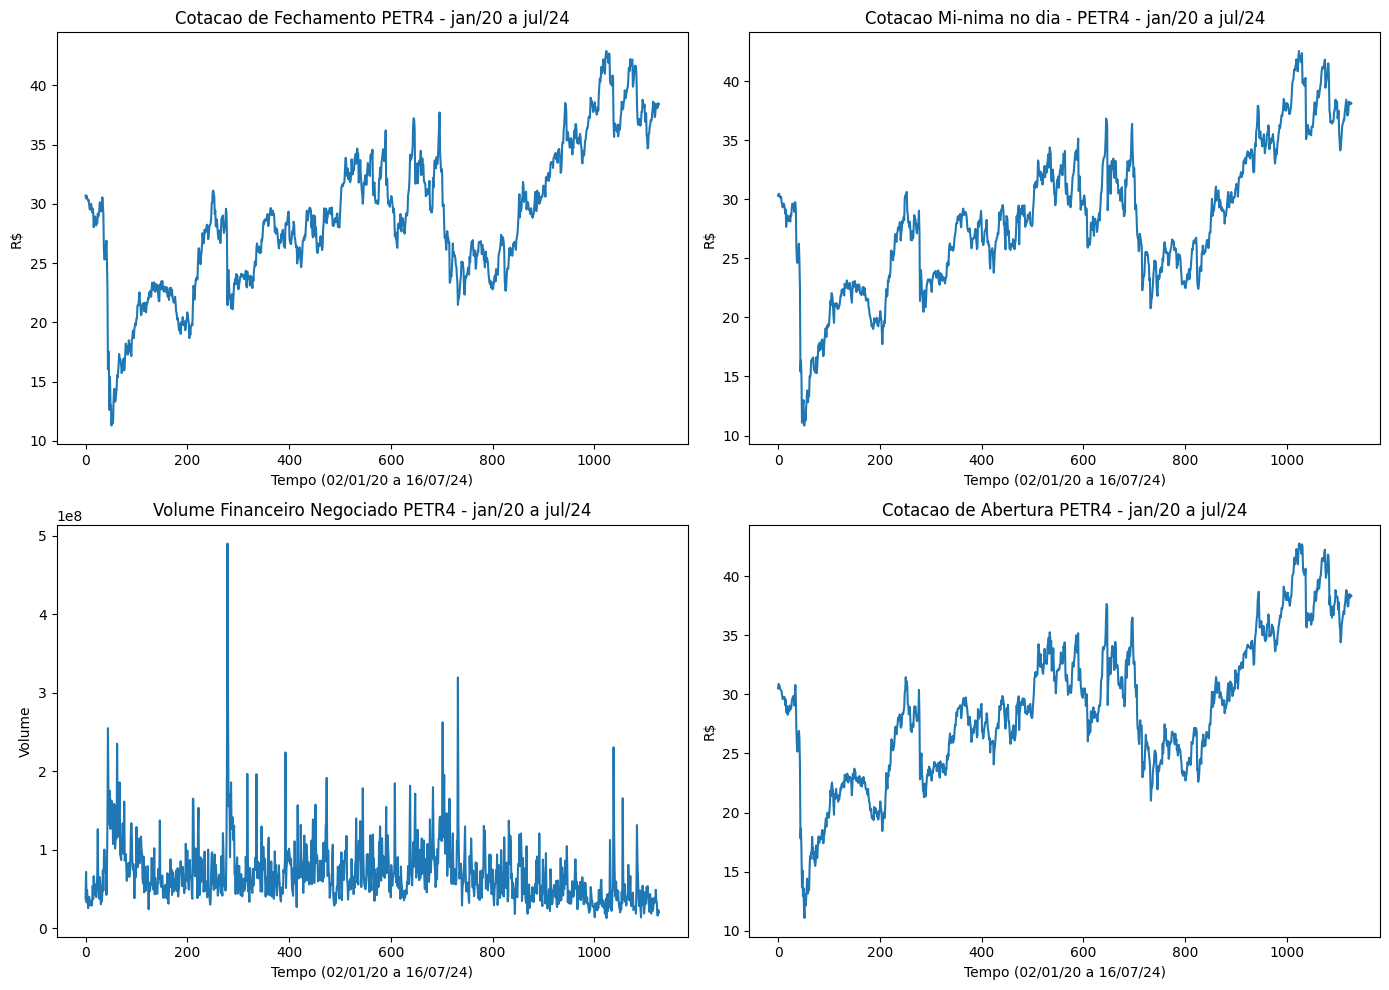

In [39]:
# In[8]: Construindo uma janela com 4 graficos - Selecione todos os comandos
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

axs[0, 0].plot(dados1['Fechamento R$'])
axs[0, 0].set_title('Cotacao de Fechamento PETR4 - jan/20 a jul/24')
axs[0, 0].set_xlabel('Tempo (02/01/20 a 16/07/24)')
axs[0, 0].set_ylabel('R$')

axs[0, 1].plot(dados1['Minimo R$'])
axs[0, 1].set_title('Cotacao Mi­nima no dia - PETR4 - jan/20 a jul/24')
axs[0, 1].set_xlabel('Tempo (02/01/20 a 16/07/24)')
axs[0, 1].set_ylabel('R$')

axs[1, 0].plot(dados1['Volume Financ. Neg'])
axs[1, 0].set_title('Volume Financeiro Negociado PETR4 - jan/20 a jul/24')
axs[1, 0].set_xlabel('Tempo (02/01/20 a 16/07/24)')
axs[1, 0].set_ylabel('Volume')

axs[1, 1].plot(dados1['Abertura R$'])
axs[1, 1].set_title('Cotacao de Abertura PETR4 - jan/20 a jul/24')
axs[1, 1].set_xlabel('Tempo (02/01/20 a 16/07/24)')
axs[1, 1].set_ylabel('R$')

plt.tight_layout()
plt.show()

In [40]:
# In[9]: Mostrar google planilhas
# Como forma alternativa, pode-se baixar esses dados diretamente
# do yfinance

# Especifica o ticker do ativo desejado (neste caso, PETR4)
ticker = "PETR4.SA"

# Define o intervalo de datas desejado
start_date = "2022-01-01"
end_date = "2024-07-16"

# Obtemos os dados do Yahoo Finance
data = yf.download(ticker, start=start_date, end=end_date)

# Exibe os primeiros registros dos dados obtidos
data.head()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,PETR4.SA,PETR4.SA,PETR4.SA,PETR4.SA,PETR4.SA,PETR4.SA
Date,,,,,,
2022-01-03 00:00:00+00:00,12.382774,29.090000,29.219999,28.530001,28.540001,52704700
2022-01-04 00:00:00+00:00,12.429599,29.200001,29.400000,28.910000,29.160000,51739200
2022-01-05 00:00:00+00:00,11.948589,28.070000,29.270000,27.940001,29.190001,78459800
2022-01-06 00:00:00+00:00,11.940076,28.049999,28.650000,27.840000,28.290001,61163100
2022-01-07 00:00:00+00:00,11.995415,28.180000,28.290001,27.820000,28.110001,47507600


In [14]:
# Salva os dados em um arquivo CSV
csv_file_path = "data/dados_petroleo.csv"
data.to_csv(csv_file_path)

In [15]:
# In[10]: Funcao para baixar dados do Yahoo Finance 
def obter_dados(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data

In [16]:
# In[11]: Funcao para plotar os 4 graficos
def plotar_graficos(data):
    fig, axs = plt.subplots(4, 1, figsize=(10, 8), sharex=True)

    # Grafico 1: Abertura
    axs[0].plot(data['Open'], label='Abertura', color='blue')
    axs[0].set_ylabel('Abertura')

    # Grafico 2: Mi­nima
    axs[1].plot(data['Low'], label='Minima', color='green')
    axs[1].set_ylabel('Minima')

    # Grafico 3: Maxima
    axs[2].plot(data['High'], label='Maxima', color='red')
    axs[2].set_ylabel('Maxima')

    # Grafico 4: Fechamento
    axs[3].plot(data['Close'], label='Fechamento', color='purple')
    axs[3].set_ylabel('Fechamento')

    axs[3].set_xlabel('Data')

    # Adiciona legenda
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()
    axs[3].legend()

    plt.tight_layout()
    plt.show()

[*********************100%***********************]  1 of 1 completed


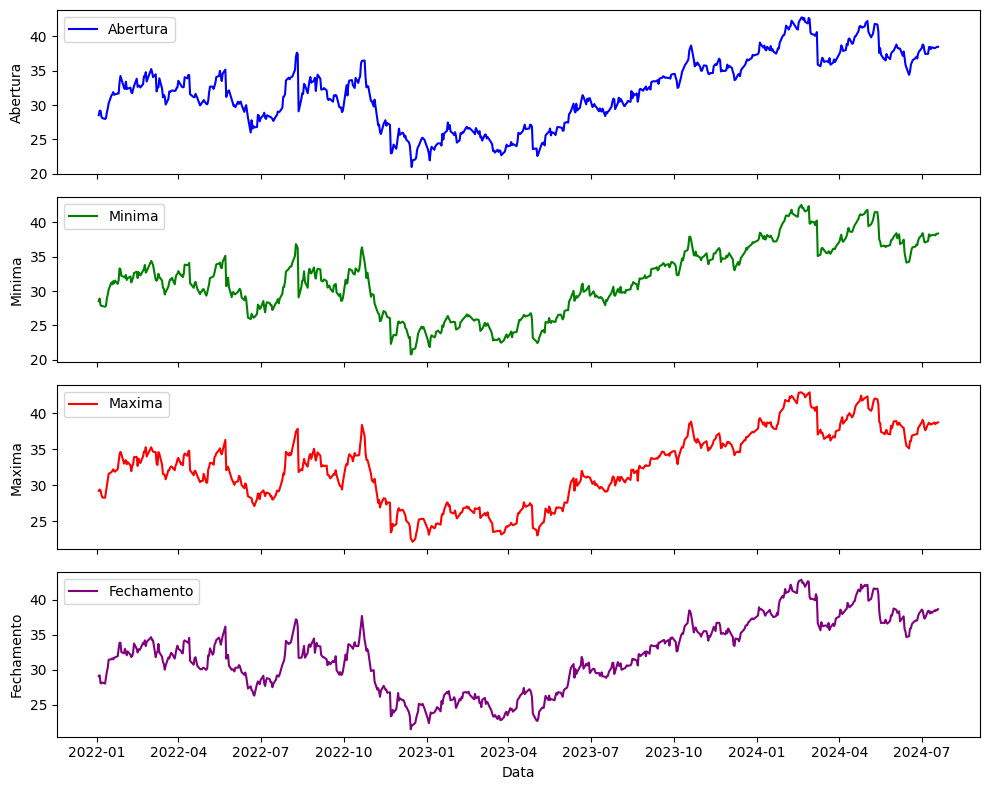

In [17]:
# USANDO FUNÇÕES

# In[12]: Define o ticker, data de inicio e data de fim
ticker = "PETR4.SA"
start_date = "2022-01-01"
end_date = "2024-07-20"

# In[13]: Obtem os dados do Yahoo Finance
dados = obter_dados(ticker, start_date, end_date)

# In[14]: Plota os 4 graficos
plotar_graficos(dados)


### base passageiros

In [18]:
# In[15]:
###############################################################################
### Trabalhando com a base de dados de Passageiros no Transporte Aereo - BR
###############################################################################

# Importando a base de dados
passageiros = pd.read_excel("data/passageiros.xlsx")

# Lendo a base de dados
passageiros.head()

,Data,passageiros
0,2011-01-01,8894294
1,2011-02-01,7212406
2,2011-03-01,8326063
3,2011-04-01,8365816
4,2011-05-01,8148295


In [19]:
# A base de dados tem duas colunas, e os passageiros transportados estao na 
# coluna 2
passag = passageiros.iloc[:, 1]

# Exibindo apenas as primeiras linhas das variaveis
passag.head()

0    8894294
1    7212406
2    8326063
3    8365816
4    8148295
Name: passageiros, dtype: int64

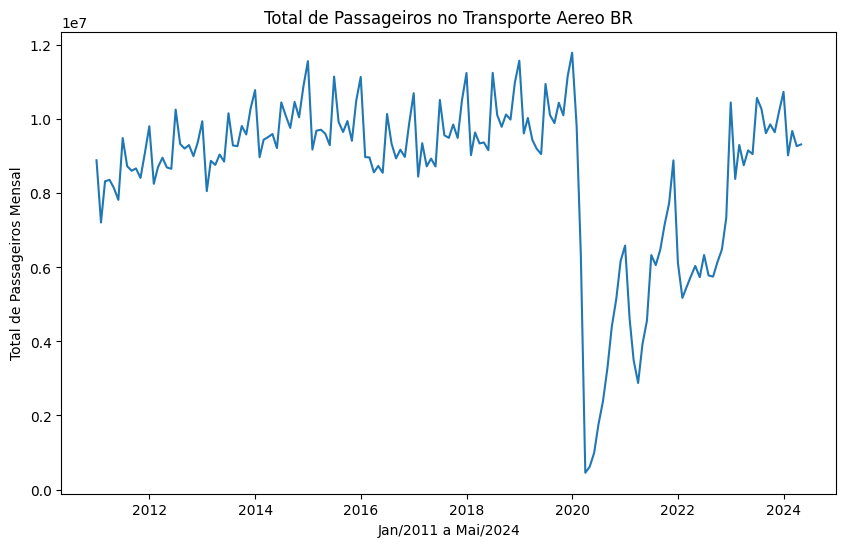

In [20]:
# Definindo o conjunto de dados passageiros como uma serie temporal
passag_ts = pd.Series(passag.values,
                      index=pd.to_datetime(passageiros.iloc[:, 0]))

# In[16]: Fazendo o grafico
plt.figure(figsize=(10, 6))
plt.plot(passag_ts)
plt.title("Total de Passageiros no Transporte Aereo BR")
plt.xlabel("Jan/2011 a Mai/2024")
plt.ylabel("Total de Passageiros Mensal")
plt.show()

### base ambev

In [41]:
# In[17]:
###############################################################################
### Trabalhando com uma Serie Temporal da Receita Trimestral da AMBEV
###############################################################################

register_matplotlib_converters()

# Importando a base de dados
ambev = pd.read_excel("data/ambev.xlsx")

# Exibindo a base de dados
ambev.head()

,Data,receita_ac,receita_t
0,2000-03-31,877.498,877.498
1,2000-06-30,1690.009,812.511
2,2000-09-30,3522.524,1832.515
3,2000-12-31,5250.345,1727.821
4,2001-03-31,1515.505,1515.505


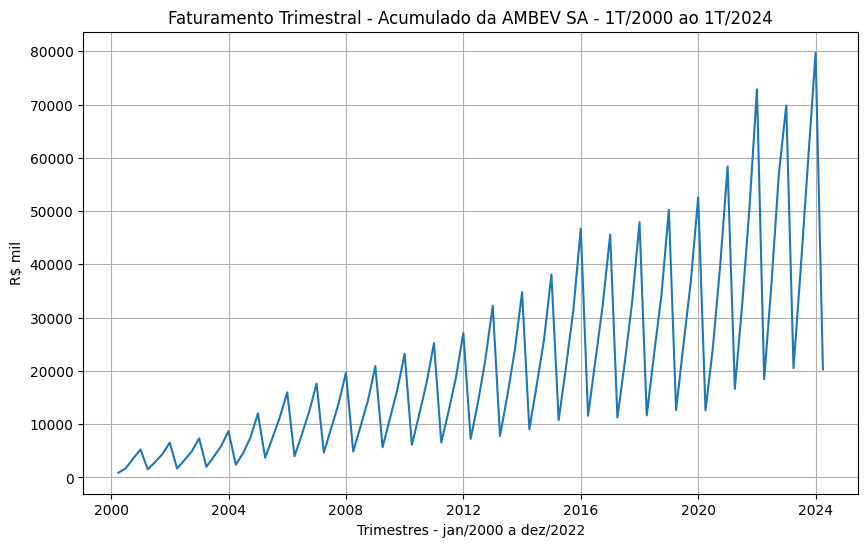

In [43]:
# Ajustando a base de dados trimestrais acumulados da Receita Liquida 
# Operacional da AMBEV
# Definindo a serie temporal com frequencia trimestral
# ATENCAO: dependendo da versao do pandas usar freq='QE'

receita = pd.Series(ambev.iloc[:, 1].values, 
                    index=pd.date_range(start='2000-01-01', periods=len(ambev), 
                                        freq='QE'))

# In[18]: Plotando o grafico
plt.figure(figsize=(10, 6))
plt.plot(receita)
plt.title("Faturamento Trimestral - Acumulado da AMBEV SA - 1T/2000 ao 1T/2024")
plt.xlabel("Trimestres - jan/2000 a dez/2022")
plt.ylabel("R$ mil")
plt.grid(True)
plt.show()

### base manchas solares

In [44]:
# In[19]:
###############################################################################
### Trabalhando com a base de dados das Manchas Solares
###############################################################################

# Importando a base de dados
manchas = pd.read_excel("data/manchas.xlsx")

manchas.head()

,Ano,meses,manchas
0,1749,1,96.7
1,1749,2,104.3
2,1749,3,116.7
3,1749,4,92.8
4,1749,5,141.7


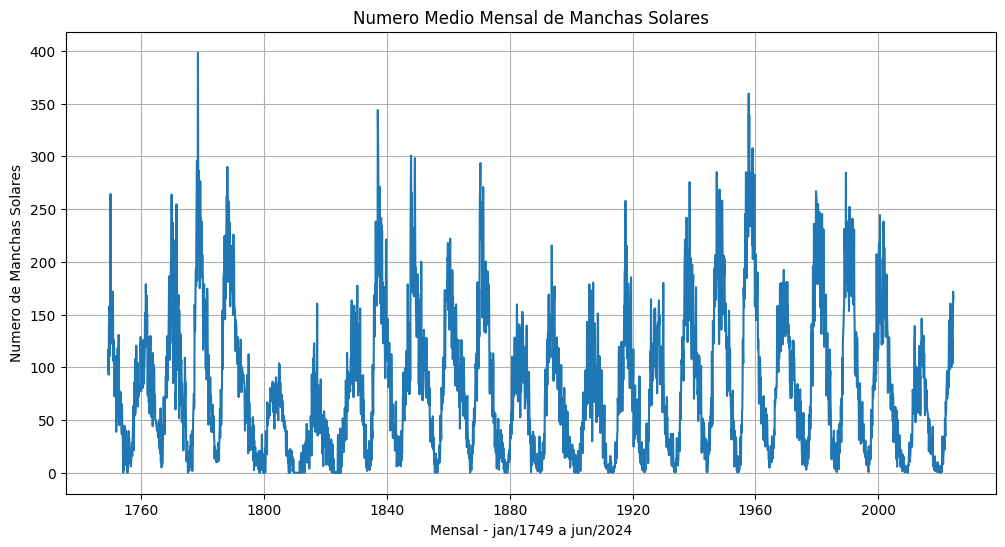

In [46]:
# Transformar o data frame em serie de tempo (Selecionar todos os comandos)
sol = pd.Series(manchas['manchas'].values, 
                index=pd.date_range(start='1749-01-01',
                                    periods=len(manchas), freq='ME'))

# In[20]: Plotando o grafico (Selecionar todos os comandos)
plt.figure(figsize=(12, 6))
plt.plot(sol)
plt.title("Numero Medio Mensal de Manchas Solares")
plt.xlabel("Mensal - jan/1749 a jun/2024")
plt.ylabel("Numero de Manchas Solares")
plt.grid(True)
plt.show()

In [47]:
# In[21]: Medidas das Estatisticas Descritivas da Serie Temporal
print("Resumo estatistico:")
print(sol.describe())
print("\nDesvio padrao:")
print(sol.std())
print("\nNumero de observacoes:")
print(len(sol))

Resumo estatistico:
count    3306.000000
mean       81.875015
std        67.654077
min         0.000000
25%        24.125000
50%        67.900000
75%       122.575000
max       398.200000
dtype: float64

Desvio padrao:
67.65407673388087

Numero de observacoes:
3306


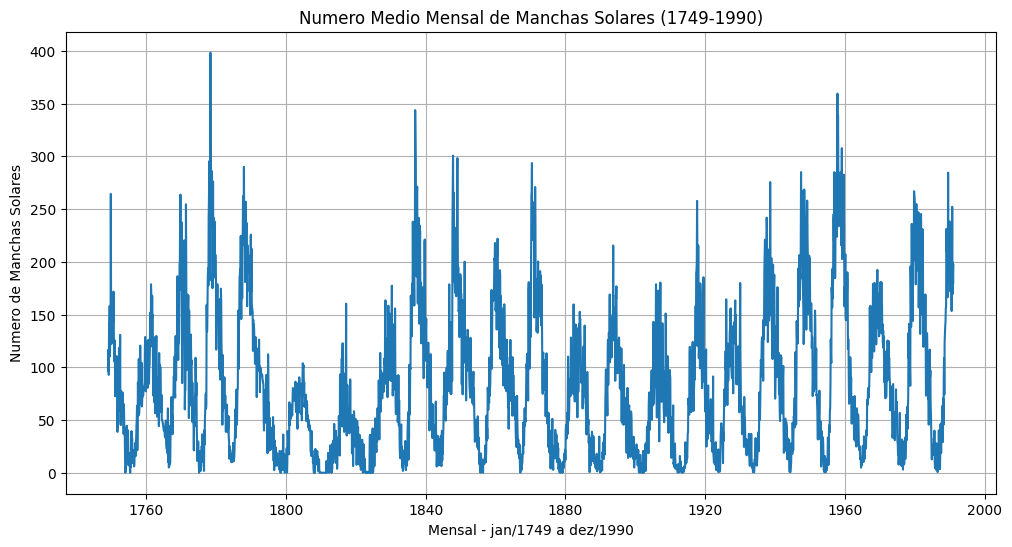

In [48]:
# In[22]: Definir uma janela de tempo da Serie Temporal
sol1 = sol['1749-01-01':'1990-12-31']

# In[23]: Plotando o grafico da janela de tempo 
plt.figure(figsize=(12, 6))
plt.plot(sol1)
plt.title("Numero Medio Mensal de Manchas Solares (1749-1990)")
plt.xlabel("Mensal - jan/1749 a dez/1990")
plt.ylabel("Numero de Manchas Solares")
plt.grid(True)
plt.show()

### base queimadas

In [50]:
# In[24]:
###############################################################################
### Trabalhando com a base de dados de Focos de Queimadas - INPE
### Fonte: https://terrabrasilis.dpi.inpe.br/queimadas/portal/
###############################################################################

# Importando a base de dados
queimadas = pd.read_excel("data/queimadas.xlsx")

queimadas.head()

,ano,meses,focos
0,1999,1,1081
1,1999,2,1284
2,1999,3,667
3,1999,4,717
4,1999,5,1811


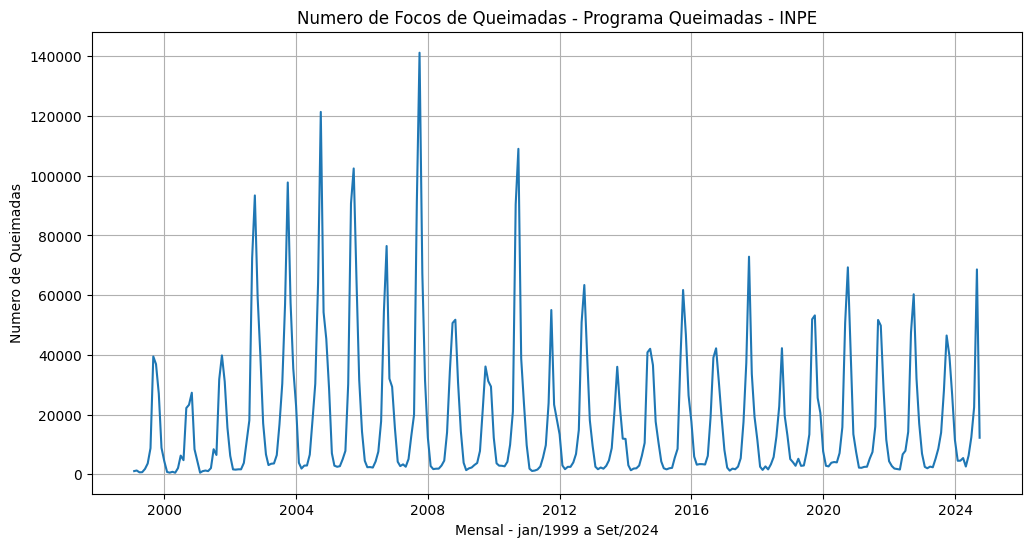

In [51]:
# Transformar o data frame em serie de tempo (Selecionar todos os comandos)
queimad = pd.Series(queimadas['focos'].values, 
                index=pd.date_range(start='1999-01-01', 
                                    periods=len(queimadas), freq='ME'))

# In[25]: Plotando o grafico (Selecionar todos os comandos)
plt.figure(figsize=(12, 6))
plt.plot(queimad)
plt.title("Numero de Focos de Queimadas - Programa Queimadas - INPE")
plt.xlabel("Mensal - jan/1999 a Set/2024")
plt.ylabel("Numero de Queimadas")
plt.grid(True)
plt.show()

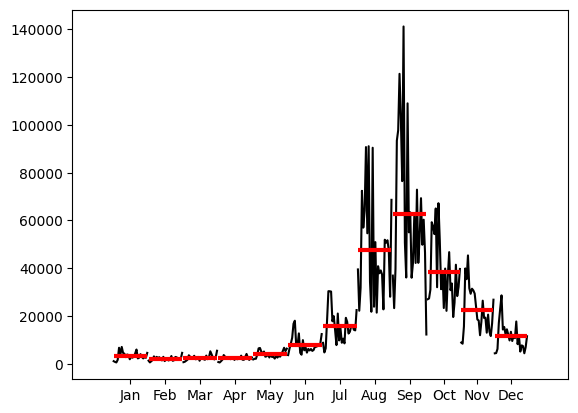

In [52]:
# In[25.1] Grafico das queimadas por mes

sm.graphics.tsa.month_plot(queimad)

plt.show()

### números aleatórios np

In [53]:
# In[26]:
###############################################################################
### Trabalhando com uma Serie Temporal de Numeros Aleatorios
###############################################################################

# Gerando numeros aleatorios com distribuicao normal padrao
aleat = pd.Series(np.random.normal(size=500))

# Visualizando os dados
aleat.head()

0    0.792035
1   -1.137427
2   -1.109613
3    1.508178
4   -2.463699
dtype: float64

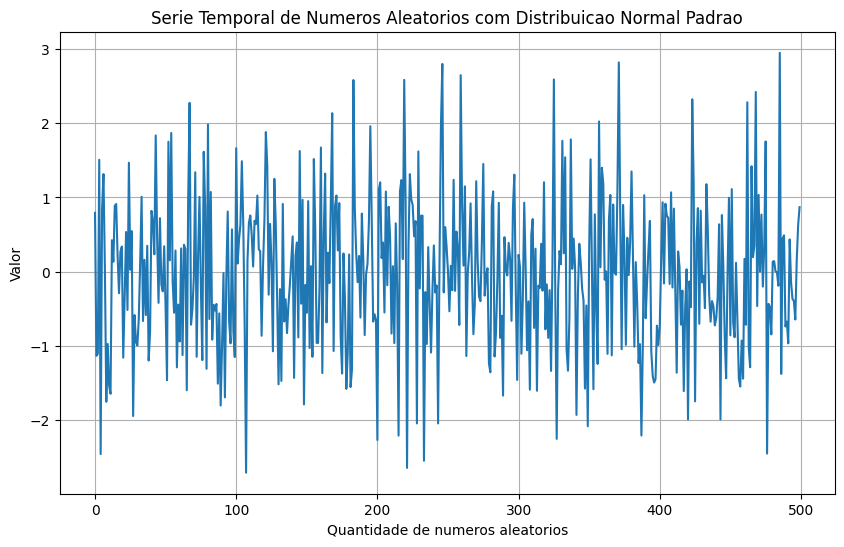

In [54]:
# In[27]: Plotando a serie temporal de numeros aleatorios com distribuicao normal 
# padrao (Selecionar todos os comandos)
plt.figure(figsize=(10, 6))
plt.plot(aleat)
plt.title("Serie Temporal de Numeros Aleatorios com Distribuicao Normal Padrao")
plt.xlabel("Quantidade de numeros aleatorios")
plt.ylabel("Valor")
plt.grid(True)
plt.show()

In [55]:
# In[28]: Calculando a media e o desvio padrao
print("Media:", aleat.mean())
print("Desvio padrao:", aleat.std())

Media: -0.03961116610751177
Desvio padrao: 1.0077890029292795


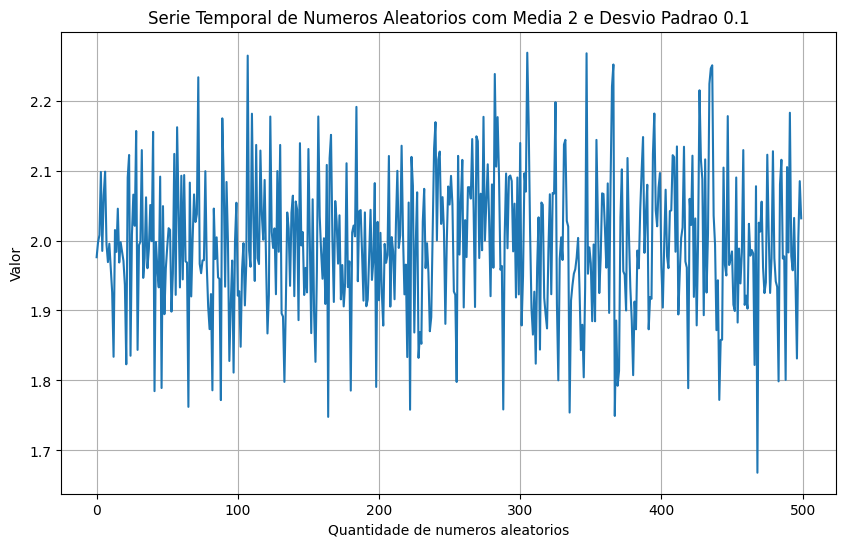

In [56]:
# In[29]: Gerando uma serie de numeros aleatorios com media 2 e desvio padrao 0.1
aleat1 = pd.Series(np.random.normal(loc=2, scale=0.1, size=500))

# In[30]: Plotando a serie temporal de numeros aleatorios com media 2 e 
# desvio padrao 0.1 (Selecionar todos os comandos)
plt.figure(figsize=(10, 6))
plt.plot(aleat1)
plt.title("Serie Temporal de Numeros Aleatorios com Media 2 e Desvio Padrao 0.1")
plt.xlabel("Quantidade de numeros aleatorios")
plt.ylabel("Valor")
plt.grid(True)
plt.show()

In [57]:
# In[31]: Calculando a media e o desvio padrao
print("Media:", aleat1.mean())
print("Desvio padrao:", aleat1.std())

Media: 1.9945136293529104
Desvio padrao: 0.1007704019337302


### passeio aleatório

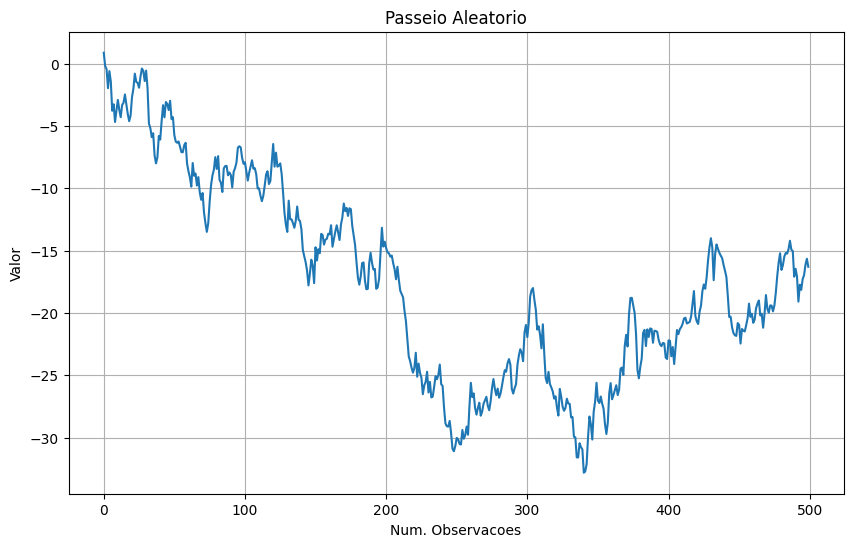

In [58]:
# In[32]:
###############################################################################
### Trabalhando com uma Serie Temporal de um Passeio Aleatorio
###############################################################################

# Gerando numeros aleatorios com distribuicao normal padrao
aleat = pd.Series(np.random.normal(size=500))

# Calculando o passeio aleatorio (soma cumulativa)
passeio = aleat.cumsum()

# In[33]: Plotando o passeio aleatorio (Selecionar todos os comandos)
plt.figure(figsize=(10, 6))
plt.plot(passeio)
plt.title("Passeio Aleatorio")
plt.xlabel("Num. Observacoes")
plt.ylabel("Valor")
plt.grid(True)
plt.show()

### base PETR4 *vs.* passeio aleatório

In [4]:
# In[34]:
###############################################################################
### Comparando a Serie PETR4(jan/2020 a jul/2024) com o Passeio Aleatorio
###############################################################################

basepetr4 = pd.read_excel("data/basepetr4.xlsx")
petr4 = basepetr4['fechamento']

# In[35]: Criando a serie petropasseio com o mesmo tamanho da petr4, inicialmente 
# todos os valores com zero
petropasseio = pd.Series(0, index=np.arange(1128))
print(petropasseio)

0       0
1       0
2       0
3       0
4       0
       ..
1123    0
1124    0
1125    0
1126    0
1127    0
Length: 1128, dtype: int64


In [7]:
# Series comecam no mesmo ponto
petropasseio.iloc[0] = petr4.iloc[0]

In [6]:
# Gerando um passeio aleatorio
for i in range(1, 1128):
    petropasseio.iloc[i] = petropasseio[i - 1] + np.random.normal()

print(petropasseio)

0       30.700000
1       29.922894
2       29.884794
3       29.698161
4       31.006687
          ...    
1123    28.104194
1124    28.151616
1125    28.304874
1126    29.600116
1127    29.087849
Length: 1128, dtype: float64


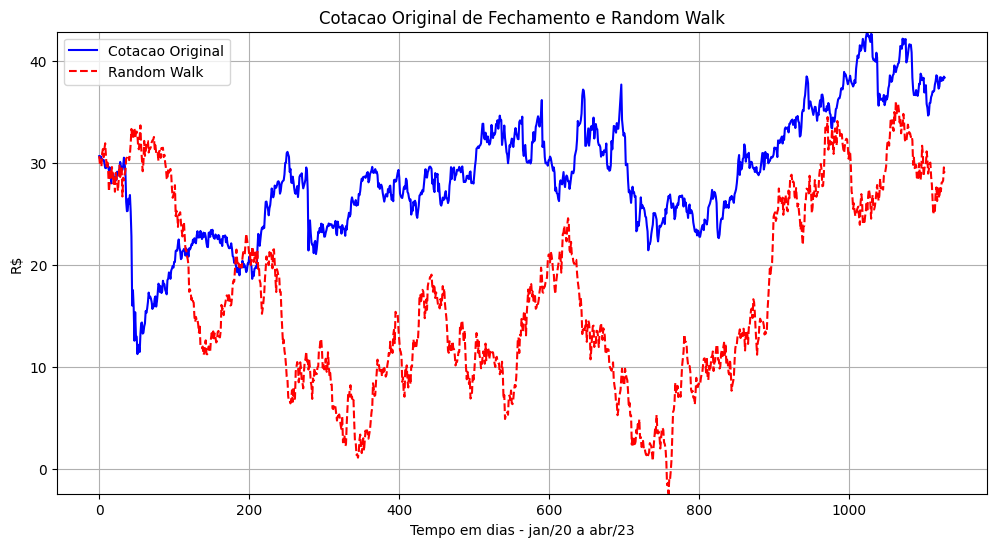

In [8]:
# In[36]: Plotando no mesmo grafico as duas series
plt.figure(figsize=(12, 6))
plt.plot(petr4, label='Cotacao Original', color='blue')
plt.plot(petropasseio, label='Random Walk', linestyle='dashed', color='red')
plt.title("Cotacao Original de Fechamento e Random Walk")
plt.xlabel("Tempo em dias - jan/20 a abr/23")
plt.ylabel("R$")
plt.ylim(min(petropasseio.min(), petr4.min()), max(petropasseio.max(), petr4.max()))
plt.legend(loc='best')
plt.grid(True)
plt.show()

### base COVID (Decomposição de Séries Temporais)

In [10]:
# In[37]:
###############################################################################
#####  DECOMPOSICAO DE SERIES TEMPORAIS
###############################################################################

##### Tendencia por medias moveis

# Analisando a serie de casos diarios de COVID 19 Brasil

# lendo a base de dados: Fonte: https://covid.saude.gov.br/
covid = pd.read_excel("data/covid.xlsx")

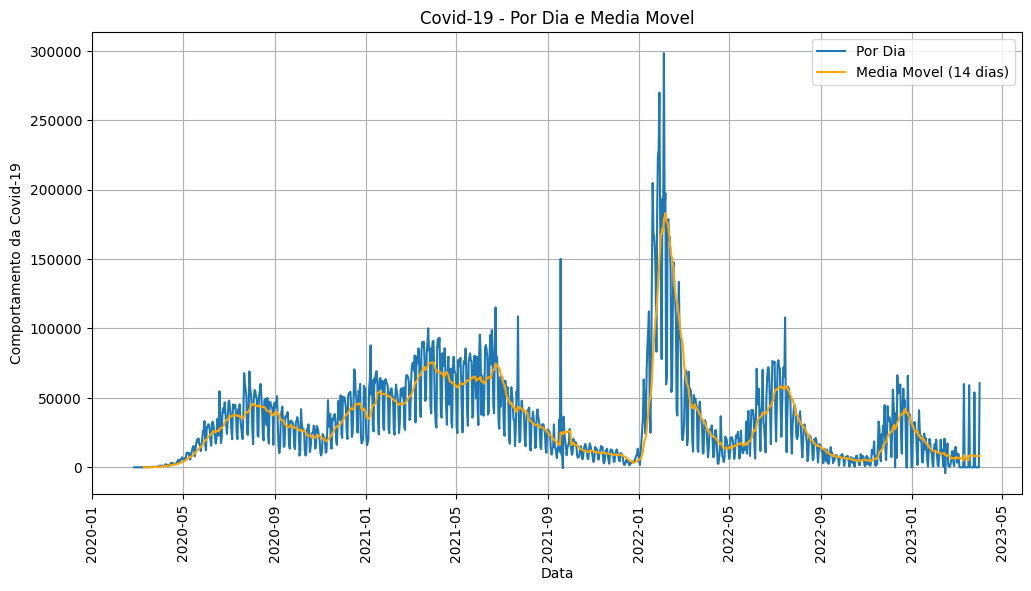

In [12]:
# In[38]: Transformando a coluna 'Data' em datetime
covid['Data'] = pd.to_datetime(covid['Data'])

# Media movel (14 dias)
covid['media_movel'] = covid['por_dia'].rolling(window=14).mean()

# In[39]: Visualizando a serie com as medias moveis (Selecionar todos os comandos)
plt.figure(figsize=(12, 6))
plt.plot(covid['Data'], covid['por_dia'], label='Por Dia')
plt.plot(covid['Data'], covid['media_movel'], label='Media Movel (14 dias)', 
         color='orange')
plt.title('Covid-19 - Por Dia e Media Movel')
plt.xlabel('Data')
plt.ylabel('Comportamento da Covid-19')
plt.legend()
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

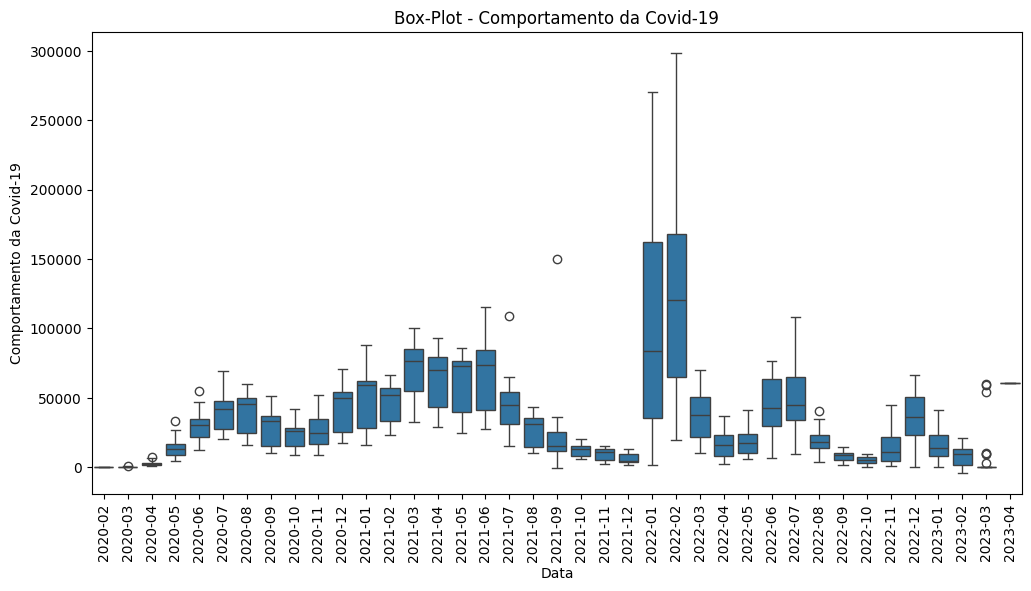

In [ ]:
# In[40]: Box-Plot para verificar se temos outliers 
plt.figure(figsize=(12, 6))
sns.boxplot(x=covid['Data'].dt.to_period('M'), y=covid['por_dia'])
plt.title('Box-Plot - Comportamento da Covid-19')
plt.xlabel('Data')
plt.ylabel('Comportamento da Covid-19')
plt.xticks(rotation=90)
plt.show()

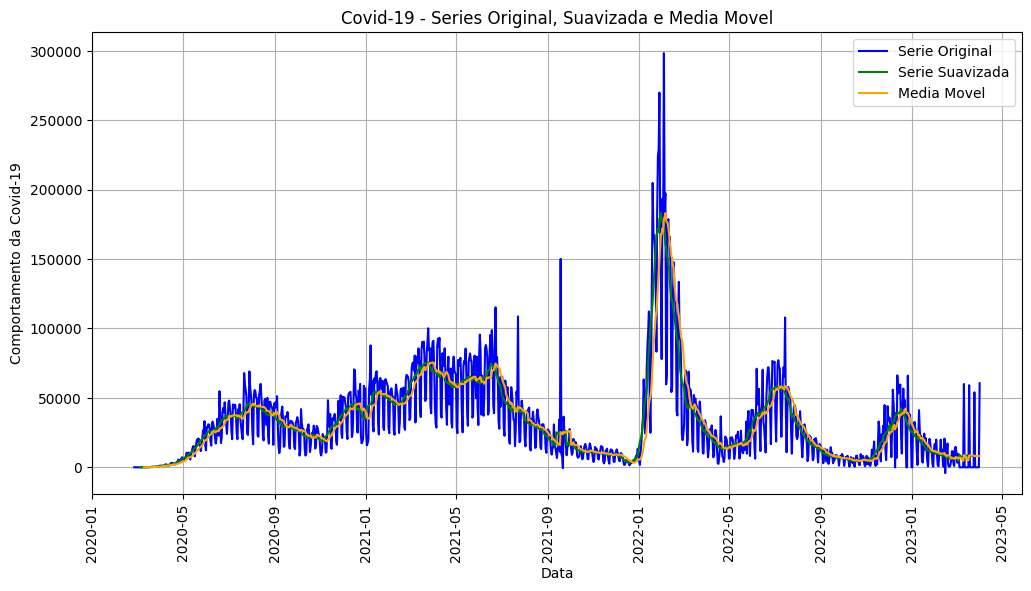

In [ ]:
# In[41]: Suavização das flutuações/picos com cálculo da média móvel
covid['covid_suave'] = covid['por_dia'].rolling(window=14, center=True).mean()
covid['media_movel_nao_centralizada'] = covid['por_dia'].rolling(window=14).mean()

# In[42]: Grafico de serie original, serie suavizada e media movel
plt.figure(figsize=(12, 6))
plt.plot(covid['Data'], covid['por_dia'], label='Serie Original', 
         color='blue')
plt.plot(covid['Data'], covid['covid_suave'], label='Serie Suavizada', 
         color='green')
plt.plot(covid['Data'], covid['media_movel'], label='Media Movel', 
         color='orange')
plt.title('Covid-19 - Series Original, Suavizada e Media Movel')
plt.xlabel('Data')
plt.ylabel('Comportamento da Covid-19')
plt.legend()
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

**Componentes de uma série temporal:**

TENDÊNCIA
Movimento oculto no dados, seguindo uma direção - crescente, decrescente ou estacionária

SAZONAL
Flutuações regulares dentro de um período completo de tempo (dia, semana, mês, etc.) 
- Representam um tipo de padrão que se repete. (picos, depressões) normalmente dentro de um ano

CÍCLICA
Flutuações de longo prazo nos dados e são similares aos fatores sazonais. Padrão que se repete com regularidade mas sem período fixo

**Métodos de decomposição:**

MULTIPLICATIVO
Normalmente aplicado a dados em que o tamanho dos efeitos sazonais é instável com o tempo  

ADITIVO
Normalmente aplicado a dados em que o tamanho dos efeitos sazonais é aproximadamente constante com o tempo 

C:\Users\madeinweb\AppData\Local\Temp\ipykernel_21832\2207894022.py:10: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  data = pd.date_range(start='2019-01-01', end='2022-12-31', freq='Q')


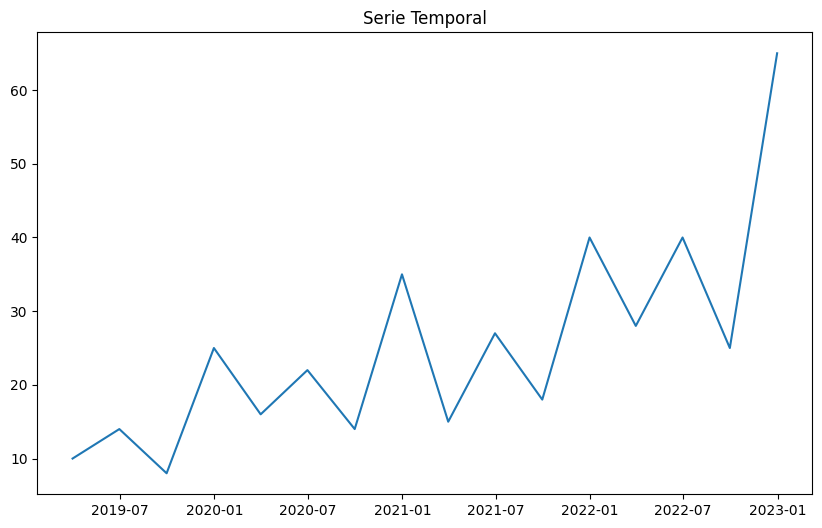

In [16]:
# In[43]:
############
# Decomposicao da serie temporal em suas componentes (Tendência, Sazonal e 
# Residuos)
# Precisamos da biblioteca statsmodels para realizar a decomposicao da serie 
# temporal nos modelos aditivo e multiplicativo alem de plotar seus componentes 
#################################

# Criar a serie temporal
data = pd.date_range(start='2019-01-01', end='2022-12-31', freq='Q')
values = [10, 14, 8, 25, 16, 22, 14, 35, 15, 27, 18, 40, 28, 40, 25, 65]
s = pd.Series(values[:len(data)], index=data)

# In[44]: Plotar a serie temporal 
plt.figure(figsize=(10, 6))
plt.plot(s)
plt.title('Serie Temporal')
plt.show()

In [20]:
# In[45]: Decomposicao pelo modelo ADITIVO
decompa = seasonal_decompose(s, model='additive', period=4)

# observando os valores da decomposicao pelo modelo aditivo
print(decompa.trend, '\n') # tendência
print(decompa.seasonal, '\n') # sazonal
print(decompa.resid) # resíduos

2019-03-31       NaN
2019-06-30       NaN
2019-09-30    15.000
2019-12-31    16.750
2020-03-31    18.500
2020-06-30    20.500
2020-09-30    21.625
2020-12-31    22.125
2021-03-31    23.250
2021-06-30    24.375
2021-09-30    26.625
2021-12-31    29.875
2022-03-31    32.375
2022-06-30    36.375
2022-09-30       NaN
2022-12-31       NaN
Freq: QE-DEC, Name: trend, dtype: float64 

2019-03-31    -5.093750
2019-06-30     2.531250
2019-09-30    -7.802083
2019-12-31    10.364583
2020-03-31    -5.093750
2020-06-30     2.531250
2020-09-30    -7.802083
2020-12-31    10.364583
2021-03-31    -5.093750
2021-06-30     2.531250
2021-09-30    -7.802083
2021-12-31    10.364583
2022-03-31    -5.093750
2022-06-30     2.531250
2022-09-30    -7.802083
2022-12-31    10.364583
Freq: QE-DEC, Name: seasonal, dtype: float64 

2019-03-31         NaN
2019-06-30         NaN
2019-09-30    0.802083
2019-12-31   -2.114583
2020-03-31    2.593750
2020-06-30   -1.031250
2020-09-30    0.177083
2020-12-31    2.510417
2021-

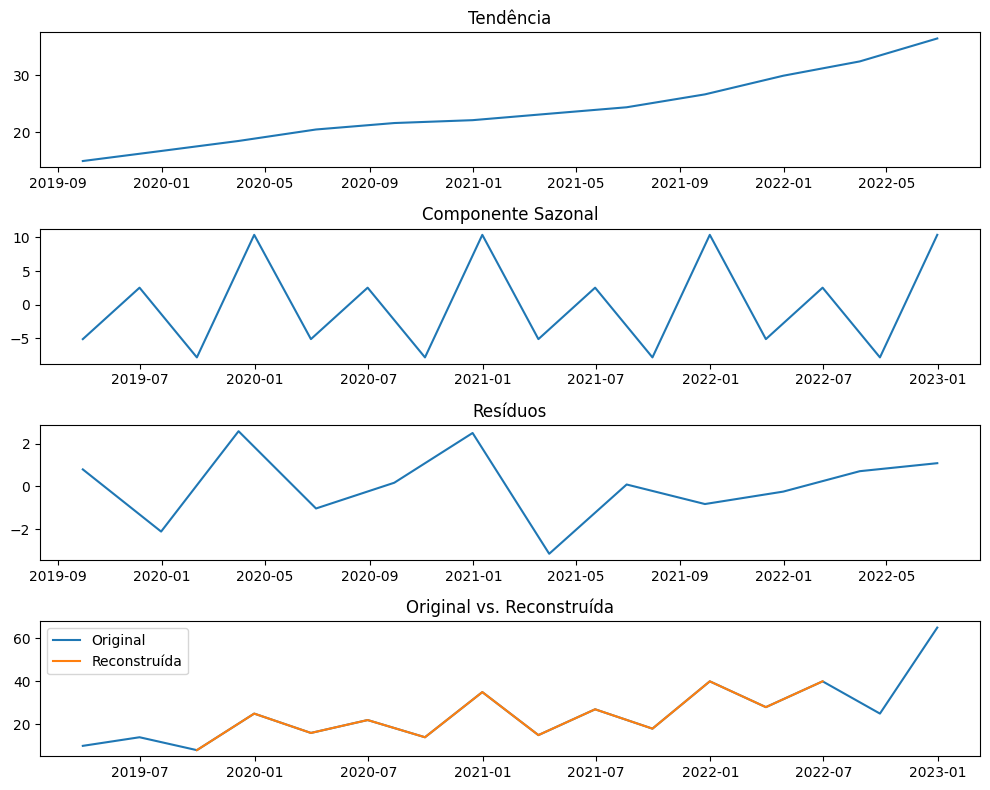

In [23]:
# In[46]: Plotar a decomposicao
plt.figure(figsize=(10, 8))
plt.subplot(4, 1, 1)
plt.plot(decompa.trend)
plt.title('Tendência')

plt.subplot(4, 1, 2)
plt.plot(decompa.seasonal)
plt.title('Componente Sazonal')

plt.subplot(4, 1, 3)
plt.plot(decompa.resid)
plt.title('Resíduos')

plt.subplot(4, 1, 4)
plt.plot(s, label='Original')
plt.plot(decompa.trend + decompa.seasonal + decompa.resid, label='Reconstruída')
plt.title('Original vs. Reconstruída')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:


# In[47]: Decomposicao pelo modelo MULTIPLICATIVO
decompm = seasonal_decompose(s, model='multiplicative', period=4)

# observando os valores da decomposicao pelo modelo multiplicativo
print(decompm.trend)
print(decompm.seasonal)
print(decompm.resid)

# In[48]: Plotar a decomposicao (Selecionar todos os comandos)
plt.figure(figsize=(10, 8))

plt.subplot(4, 1, 1)
plt.plot(decompm.trend)
plt.title('Tendencia')

plt.subplot(4, 1, 2)
plt.plot(decompm.seasonal)
plt.title('Componente Sazonal')

plt.subplot(4, 1, 3)
plt.plot(decompm.resid)
plt.title('Resi­duos')

plt.subplot(4, 1, 4)
plt.plot(s, label='Original')
plt.plot(decompm.trend * decompm.seasonal * decompm.resid, label='Reconstrui­da')
plt.title('Original vs. Reconstruida')
plt.legend()

plt.tight_layout()
plt.show()


# In[49]:
###############################################################################
## Trabalhando com a serie do PIB do Brasil 
######################################################

pib = pd.read_excel("pib_mensal.xlsx", parse_dates=True, index_col=0)
 
# Transformar a base de dados em um objeto de classe ts
pib_ts = pd.Series(pib['pib'].values, index=pib.index)
 
# In[50]: Plotar a serie temporal (Selecionar todos os comandos)
plt.figure(figsize=(10, 6))
plt.plot(pib_ts.index, pib_ts.values, label='PIB', color='blue')
plt.title('Produto Interno Bruto - PIB')
plt.xlabel('Jan/2004 a Mai/2024')
plt.ylabel('R$ Milhares')
plt.legend()
plt.show()

# In[51]: Decompondo o PIB pelo modelo aditivo
decomp_aditivo = seasonal_decompose(pib_ts, model='additive', period=12)

# In[52]: Plotando a decomposicao (Selecionar todos os comandos)
decomp_aditivo.plot()
plt.suptitle('Decomposicao Aditiva do PIB')
plt.show()

# In[53]: Decompondo o PIB pelo modelo multiplicativo
decomp_multiplicativo = seasonal_decompose(pib_ts, model='multiplicative', 
                                           period=12)

# In[54]: Plotando a decomposicao (Selecionar todos os comandos)
decomp_multiplicativo.plot()
plt.suptitle('Decomposicao Multiplicativa do PIB')
plt.show()

# In[55]:
###############################################################################
##### Aplicando a decomposicao das series temporais
##### usando a palheta de cores viridis
############# decomposicao da serie temporal do PIB Mensal BR

from statsmodels.tsa.seasonal import seasonal_decompose

# Configurar o estilo dos graficos e a paleta de cores
sns.set(style='whitegrid', palette='viridis')

# Carregar os dados do Excel
pib = pd.read_excel('pib_mensal.xlsx')

# Transformar a base de dados em um objeto de serie temporal (Selecione todos
# os comandos)
pib_ts = pd.Series(pib.iloc[:, 1].values, 
                   index=pd.date_range(start='2004-01-01',
                                       periods=len(pib), freq='M'))

# In[56]: Fazer a plotagem da serie temporal (Selecione todos os comandos)
plt.figure(figsize=(10, 6))
plt.plot(pib_ts, color=sns.color_palette("viridis", 2)[0])
plt.title('Produto Interno Bruto - PIB')
plt.xlabel('Jan/2004 a Mai/2024')
plt.ylabel('R$ milhares')
plt.show()

# In[57]: Decompor o PIB pelo modelo aditivo
decomp_add = seasonal_decompose(pib_ts, model='additive', period=12)

# Decompor o PIB pelo modelo multiplicativo
decomp_mul = seasonal_decompose(pib_ts, model='multiplicative', period=12)

# In[58]: Funcao para plotar decomposicao (Selecionar todos os comandos)
def plot_decomposition(decomposition, title):
    colors = sns.color_palette("viridis", 4)
    
    plt.figure(figsize=(14, 10))
    plt.suptitle(title, fontsize=16)

    plt.subplot(411)
    plt.plot(decomposition.observed, label='Observado', color=colors[0])
    plt.legend(loc='upper left')
    plt.grid(True)

    plt.subplot(412)
    plt.plot(decomposition.trend, label='Tendencia', color=colors[1])
    plt.legend(loc='upper left')
    plt.grid(True)

    plt.subplot(413)
    plt.plot(decomposition.seasonal, label='Sazonalidade', color=colors[2])
    plt.legend(loc='upper left')
    plt.grid(True)

    plt.subplot(414)
    plt.plot(decomposition.resid, label='ResÃiduos', color=colors[3])
    plt.legend(loc='upper left')
    plt.grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# In[59]: Plotar decomposicao aditiva
plot_decomposition(decomp_add, 'Decomposicao Aditiva do PIB Mensal BR')

# Plotar decomposicao multiplicativa
plot_decomposition(decomp_mul, 'Decomposicao Multiplicativa do PIB Mensal BR')


# In[60]:
###############################################################################
### Estatisticas de Acuracia das previsoes
###############################################################################

# from sklearn.metrics import accuracy_score

# Exemplo
reais = np.array([1, 2, 3, 5, 6, 8, 9])
previstos = np.array([1, 3, 3, 4, 6, 7, 9])

# Calculo do Erro
erro = reais - previstos

# Calculo do Erro Medio
merror = sum(erro)/len(erro)
merror

# Calculo do Erro Absoluto Medio
mae = mean_absolute_error(reais, previstos)
mae

# Calculo da Raiz Quadrada do Erro Medio
rmse = mean_squared_error(reais, previstos, squared=False)
rmse

# Calculo do Erro Percentual Medio
erro_percentual = (reais - previstos)/reais
mpe = me = sum(erro_percentual)/len(erro)*100
mpe

# Calculo do Erro Absoluto Percentual Medio
mape = mean_absolute_percentage_error(reais,previstos)*100
mape

# In[61]: Calculo do Coeficiente U de Theil
# Funcao para calculo do Coeficiente U de Theil (selecionar todos os comandos)

def division(measure, previousI):
  return measure / previousI

def power(measure):
  return np.power(measure, 2)

def summation(measure):
  return np.sum(measure)

def mean(N, measure):
  return (1/N) * measure

def sqrt(measure):
  return np.sqrt(measure)

def computeTheilU2(y_true, y_pred):
    N = len(y_true)
    
    subtractionNumerator = y_pred[1:] - y_true[1:]
    divisionNumerator = division(subtractionNumerator, y_true[:-1])
    powerNumerator = power(divisionNumerator)
    summationNumerator = summation(powerNumerator)
    meanNumerator = mean(N, summationNumerator)
    numerator = sqrt(meanNumerator)
    
    subtractionDenominator = y_true[1:] - y_true[:-1]
    powerDenominator = power(division(subtractionDenominator, y_true[:-1]))
    denominator = sqrt(mean(N, summation(powerDenominator)))
        
    theilU2 = numerator / denominator
    
    return theilU2

theil = computeTheilU2(reais,previstos)

theil

# In[62]: Exibir as metricas de acuracia (Selecione todos os comandos)
print(" Indicadores de Acuracia")
print(f'ME - Mean Error: {merror:.2f}')
print(f'MAE - Mean Absolute Error: {mae:.2f}')
print(f'RMSE - Raiz Quadrada do Erro Medio: {rmse:.2f}')
print(f'MPE - Mean Percentage Error: {mpe:.2f}')
print(f'MAPE - Mean Absolute Percentage Error: {mape:.2f}')
print(f'THEIL_U - Theils Inequality Coefficient: {theil:.4f}')


# In[63]:
###############################################################################
###############################################################################
### Metodos SIMPLES de Previsao de Series Temporais
###############################################################################
###############################################################################

# Serie - Exemplo
 
serie = np.array([3, 5, 9, 20, 12, 17, 22, 23, 51, 41, 56, 75, 60, 75, 88])


# In[64]:
###############################################################################
### Metodo NAIVE 
###############################################################################

from scipy import stats

# Funcao para realizar previsao naive e calcular intervalos de confianca 
# ajustados

def naive_forecast(time_series, h=3, confidence_level=0.95):
    # A ultima observacao da serie
    last_observation = time_series[-1]
    
    # Previsoes naive para h passos a  frente
    forecasts = np.array([last_observation] * h)
    
    # Calculando os erros de previsao
    errors = time_series[1:] - time_series[:-1] 
    erro2=errors*errors
    std_error =np.sqrt(erro2.mean())  # Desvio dos erros
    
    # Valor cri­tico da distribuicao normal para o ni­vel de confianca desejado
    z_value = stats.norm.ppf((1 + confidence_level) / 2)
    
    # Calculando os intervalos de confianca com ajuste para h passos a  frente
    confidence_intervals = [
        (forecast - z_value * std_error * np.sqrt(step+1), 
         forecast + z_value * std_error * np.sqrt(step+1))
        for step, forecast in enumerate(forecasts)
    ]
    
    # Criando um DataFrame para armazenar previsoes e intervalos de confianca
    forecast_df = pd.DataFrame({
        "Previsao": forecasts,
        "IC Inferior": [ci[0] for ci in confidence_intervals],
        "IC Superior": [ci[1] for ci in confidence_intervals]
    }, index=[f'T+{i+1}' for i in range(h)])
    
    return forecast_df, confidence_intervals

# In[65]: Funcao para plotar a serie temporal com previsoes e intervalos de confianca 
def plot_naive_forecast(time_series, forecast_df):
    n = len(time_series)
    h = len(forecast_df)
    
    plt.figure(figsize=(10, 6))
    
    # Plotando os valores reais da serie temporal
    plt.plot(range(n), time_series, label='Serie Temporal', color='blue')
    
    # Plotando os valores previstos
    plt.plot(range(n-1, n+h), np.concatenate(([time_series[-1]], 
                                              forecast_df['Previsao'])), 
             label='Previsao (Naive)', linestyle='--', marker='o', color='orange')

    # Plotando os limites inferior e superior dos intervalos de confianca
    plt.plot(range(n, n+h), forecast_df['IC Inferior'], 
             label='IC Inferior (95%)', linestyle='--', color='red')
    plt.plot(range(n, n+h), forecast_df['IC Superior'],
             label='IC Superior (95%)', linestyle='--', color='green')

    # Adicionando ro­tulos e legendas
    plt.title('Previsao Naive com Intervalos de Confianca (95%)')
    plt.xlabel('Tempo')
    plt.ylabel('Valor')
    plt.legend()
    plt.grid(True)
    
    # Exibindo o grafico
    plt.show()

# In[66]: Aplicando a previsao naive com intervalos de confianca ajustados
naiveforecast_df, confidence_intervals = naive_forecast(serie, h=3)

# Mostrando o DataFrame com previsoes
print(naiveforecast_df)

# Plotando os resultados com previsoes e intervalos de confianca como linhas
plot_naive_forecast(serie, naiveforecast_df)


# In[67]:
###############################################################################
### Metodo de previsao pela MEDIA 
###############################################################################

# Funcao para realizar previsao pela media e calcular intervalos de confianca 

def forecast_with_mean(time_series, steps_ahead, confidence=0.95):
    # Calcular a media da serie
    mean_series = np.mean(time_series)
    
    # Calcular os erros (resi­duos) da previsao pela media
    errors = time_series - mean_series
    
    # Calcular o desvio padrao dos erros
    std_errors = np.std(errors, ddof=1)
    
    # Prever com base na media
    forecast = [mean_series] * steps_ahead

    # Calcular intervalo de confianca usando o desvio padrao dos erros
    n = len(time_series)
    alpha = 1 - confidence
    t_value = stats.t.ppf(1 - alpha/2, df=n-1)  
    margin_of_error = t_value * std_errors*np.sqrt(1+1/len(time_series))
    
    # Inferior e superior
    lower_bound = [mean_series - margin_of_error] * steps_ahead
    upper_bound = [mean_series + margin_of_error] * steps_ahead

    return forecast, lower_bound, upper_bound

# In[68]: Funcao para plotar a serie original e a previsao
def plot_forecast_with_mean(time_series, forecast, lower_bound,
                                            upper_bound, steps_ahead):
    # Plotar a serie original
    plt.plot(range(len(time_series)), time_series, label="Serie Original", 
             marker='o')
    
    # Criar eixo de tempo para previsao
    forecast_range = range(len(time_series), len(time_series) + steps_ahead)
    
    # Plotar a previsao
    plt.plot(forecast_range, forecast, label="Previsao", marker='o', 
             linestyle='--')
    
    # Plotar intervalo de confianca
    plt.fill_between(forecast_range, lower_bound, upper_bound, color='gray',
                     alpha=0.05, label='Intervalo de Confianca')
    
    # Detalhes do grafico
    plt.xlabel("Tempo")
    plt.ylabel("Valores")
    plt.legend()
    plt.title("Serie Original e Previsao com Intervalo de Confianca pela media")
    plt.show()

# In[69]: Definir numero de passos a  frente
h = 3

# Gerar previsao e intervalos de confianca
forecast_mean, lower_bound, upper_bound = forecast_with_mean(serie, h)

forecast_mean

# In[70]: Exibir resultados
print("Previsao", forecast_mean)
print("Limite inferior do intervalo de confianca:", lower_bound)
print("Limite superior do intervalo de confianca:", upper_bound)

# In[71]: Chamar a funcao de plotagem
plot_forecast_with_mean(serie, forecast_mean, lower_bound, upper_bound, h)


# In[72]:
###############################################################################

###############################################################################
### Metodo de previsao com DRIFT
###############################################################################

# Funcao para calcular a previsao pelo modelo de Drift
def drift_forecast(time_series, steps_ahead, confidence=0.95):
    n = len(time_series)
    
    # Previsao pelo modelo de drift
    drift = (time_series[-1] - time_series[0]) / (n - 1)
    forecast = [time_series[-1] + (i + 1) * drift for i in range(steps_ahead)]
    
    # Calculo dos erros 
    predicted_values = []
    for i in range(1, n):
        predicted_values.append(time_series[i-1] + drift)
    
    # Calcular os erros como a diferenca entre os valores reais e os previstos
    errors = time_series[1:] - np.array(predicted_values)
    erro2=errors*errors
   
    # Calcular o desvio dos erros
    std_errors = np.sqrt(erro2.mean())
 
    # variavel auxiliar para o intervalo de confianca
    calc = len(errors)
  
    # Calcular intervalo de confianca usando o desvio padrao dos erros
    z_value = stats.norm.ppf((1 + confidence) / 2)
   
    # Limites inferior e superior
    lower_bound = [forecast[i] -
                   z_value * std_errors * np.sqrt((i+1)*(1+(i+1)/(calc -1)))
                   for i in range(steps_ahead)]
    upper_bound = [forecast[i] +
                   z_value * std_errors * np.sqrt((i+1)*(1+(i+1)/(calc -1))) 
                   for i in range(steps_ahead)]
        
    return forecast, lower_bound, upper_bound

# In[73]: Funcao para plotar a serie original e a previsao pelo modelo de Drift
def plot_forecast_with_drift(time_series, forecast, lower_bound,
                                            upper_bound, steps_ahead):
    # Plotar a serie original
    plt.plot(range(len(time_series)), time_series, label="Serie Original",
             marker='o')
    
    # Criar eixo de tempo para previsao
    forecast_range = range(len(time_series), len(time_series) + steps_ahead)
    
    # Plotar a previsao
    plt.plot(forecast_range, forecast, label="Previsao (Drift)", marker='o', 
             linestyle='--')
    
    # Plotar intervalo de confianca
    plt.fill_between(forecast_range, lower_bound, upper_bound, color='gray', 
                     alpha=0.05, label='Intervalo de Confianca')
    
    # Detalhes do grafico
    plt.xlabel("Tempo")
    plt.ylabel("Valores")
    plt.legend()
    plt.title("Serie Original e Previsao pelo Modelo de Drift com Intervalo de Confianca")
    plt.show()

# In[74]: Definir numero de passos a  frente
h = 5

# Gerar previsao e intervalos de confianca pelo modelo de Drift
forecast_drift, lower_bound, upper_bound = drift_forecast(serie, h)

forecast_drift
lower_bound
upper_bound

# Chamar a funcao de plotagem
plot_forecast_with_drift(serie, forecast_drift, lower_bound, upper_bound, h)


# In[75]:
###############################################################################
### Metodo de previsao com NAIVE SAZONAL
###############################################################################

# Funcao para rodar o modelo Naive Sazonal com intervalos de confianca
def seasonal_naive_forecast(time_series, season_length, steps_ahead, confidence=0.95):
    """
    time_series: Série temporal
    season_length: Período sazonal (ex: 12 meses para sazonalidade mensal)
    steps_ahead: O número de períodos à frente para previsão
    confidence: Nível de confiança (95% por padrão)
    """
    # Prever o valor com base na sazonalidade anterior
    forecast = [time_series.iloc[-season_length + i] for i in range(steps_ahead)]
    
    # Previsão dos valores dentro da série histórica para obter resíduos
    predicted_values = [time_series.iloc[i - season_length] for i in range(season_length, len(time_series))]
  
    # Calcular os erros residuais
    residuals = time_series.iloc[season_length:] - np.array(predicted_values)
    
    # Calcular o quadrado dos erros (resíduos)
    errors2 = residuals ** 2
    
    # Calcular o desvio padrão dos erros
    std_residuals = np.sqrt(errors2.mean())
 
    # Calcular o valor crítico z para o intervalo de confiança
    z_value = stats.norm.ppf((1 + confidence) / 2)
    
    # Calcular a margem de erro
    margin_of_error = z_value * std_residuals
    
    # Definir limites inferiores e superiores dos intervalos de confiança
    lower_bound = [forecast[i] - margin_of_error * np.sqrt((i // season_length) + 1) for i in range(steps_ahead)]
    upper_bound = [forecast[i] + margin_of_error * np.sqrt((i // season_length) + 1) for i in range(steps_ahead)]
    
    return forecast, lower_bound, upper_bound

# In[76]: Funcao para plotar a serie original, previsao e intervalos de confianca
def plot_seasonal_naive_forecast(time_series, forecast, lower_bound,
                                 upper_bound, steps_ahead):
    # Plotar a serie original
    plt.plot(range(len(time_series)), time_series, label="Serie Original",
             marker='o')
    
    # Criar eixo de tempo para previsao
    forecast_range = range(len(time_series), len(time_series) + steps_ahead)
    
    # Plotar a previsao
    plt.plot(forecast_range, forecast, label="Previsao (Naive Sazonal)", 
             marker='o', linestyle='--')
    
    # Plotar intervalo de confianca
    plt.fill_between(forecast_range, lower_bound, upper_bound, color='gray',
                     alpha=0.2, label='Intervalo de Confianca')
    
    # Detalhes do grafico
    plt.xlabel("Tempo")
    plt.ylabel("Valores")
    plt.legend()
    plt.title("Serie Original e Previsao pelo Modelo Naive Sazonal com Intervalo de Confianca")
    plt.show()

# In[77]: Importando a base de dados
# pip install --upgrade openpyxl

airp = pd.read_excel("airpassengers.xlsx")

# Lendo a base de dados
print(airp.head())

# In[78]: Definindo a serie temporal com frequencia mensal
airpas = pd.Series(airp.iloc[:, 1].values, 
                    index=pd.date_range(start='2007-01-01', periods=len(airp), 
                                        freq='M'))

# In[79]: Plotando o grafico
plt.figure(figsize=(10, 6))
plt.plot(airpas)
plt.title("Transporte Aereo de Passageiros - jan/2007 ao dez/2018")
plt.xlabel("Meses - jan/2007 a dez/2018")
plt.ylabel("Numero de pessoas")
plt.grid(True)
plt.show()

# In[80]: Definir os parametros de sazonalidade e numero de passos a  frente
season_length = 12  # Por exemplo, 12 meses para sazonalidade anual
steps_ahead = 12  # Prevendo os proximos 12 peri­odos (um ano a  frente - h)

# In[81]: Gerar previsao e intervalos de confianca pelo modelo Naive Sazonal
forecast, lower_bound, upper_bound = seasonal_naive_forecast(airpas, 
                                                season_length, steps_ahead)

forecast
lower_bound
upper_bound

# Chamar a funcao de plotagem
plot_seasonal_naive_forecast(airpas, forecast, lower_bound, upper_bound, 
                             steps_ahead)


# In[82]:
###############################################################################
### Modelos de SUAVIZACAO EXPONENCIAL - Simples
###############################################################################

# Base simples
base = pd.Series([3, 5, 9, 20, 12, 17, 22, 23, 51, 41, 56, 75, 60, 75, 88])

# Visualização da base de dados
plt.plot(base)
plt.title("Base Simples")
plt.show()


# In[83]:
###############################################################################
# Suavização Exponencial Simples (SES) - Modelagem simples sem tendência/sazonalidade
###############################################################################

# Criando o modelo SES
ses_model = SimpleExpSmoothing(base).fit()
print(ses_model.summary())

ses_forecast = ses_model.forecast(3)

# Visualização dos valores previstos
print("Previsões (SES):")
print(ses_forecast)

# Valores ajustados

print("Valores Ajustados (SES):")
print(ses_model.fittedvalues)

# In[84]: Visualização dos dados e previsões com intervalos de confiança
plt.plot(base, label="Base de Dados")
plt.plot(ses_model.fittedvalues, label="Ajustado (SES)")
plt.plot(np.arange(len(base), len(base) + 3), ses_forecast, label="Previsão (SES)")
plt.title("Suavização Exponencial Simples (SES)")
plt.legend()
plt.show()


# In[85]:
###############################################################################
# Modelo de Holt com Tendência
###############################################################################

# Modelo Holt
holt_model = Holt(base).fit()
print(holt_model.summary())

holt_forecast = holt_model.forecast(3)

# Visualizando os valores previstos
print("Previsão com Holt: ")
print(holt_forecast)

# In[86]: Visualização dos dados e previsões
plt.plot(base, label="Dados Originais")
plt.plot(holt_model.fittedvalues, label="Ajustado (Holt)")
plt.plot(np.arange(len(base), len(base) + 3), holt_forecast, label="Previsão (Holt)")
plt.title("Modelo de Holt com Tendência")
plt.legend()
plt.show()


# In[87]:
###############################################################################
# Modelo Holt-Winters com Tendência (Holt-Winters atribuindo a tendencia)
###############################################################################

ajuste2 = HW(base, trend='add', seasonal=None).fit()
print(ajuste2.summary())

fitted_ajuste2 = ajuste2.fittedvalues
print("Valores ajustados (Holt-Winters com tendência):")
print(fitted_ajuste2)

# Previsão de 5 passos à frente
prevajuste2 = ajuste2.forecast(5)
print("Previsão para os próximos 5 períodos:")
print(prevajuste2)

# In[88]: Visualização dos dados ajustados e previsão
plt.plot(base, label="Dados originais")
plt.plot(fitted_ajuste2, label="Ajustado (Holt-Winters com tendência)")
plt.plot(np.arange(len(base), len(base) + 5), prevajuste2, label="Previsão")
plt.title("Holt-Winters com Tendência")
plt.legend()
plt.show()


# In[89]:
###############################################################################
# Modelo de Holt-Winters com Tendência e Sazonalidade
###############################################################################

# Nova base de dados com sazonalidade
base2 = pd.Series([10, 14, 8, 25, 16, 22, 14, 35, 15, 27, 18, 40, 28, 40, 25, 65],
                  index=pd.date_range(start='2019-01-01', periods=16, freq='Q'))


def plot_holtwinters(model, fitted_values, forecast, model_type):
    plt.figure(figsize=(10, 6))

    # Obter datas para o período da previsão
    forecast_index = pd.date_range(start=base2.index[-1] + pd.offsets.QuarterEnd(), periods=len(forecast), freq='Q')

    # Plotando os dados originais, ajustados e previsão
    plt.plot(base2.index, base2, label="Dados Originais", marker='o', color='blue')
    plt.plot(base2.index, fitted_values, label="Valores Ajustados", marker='o', color='green')
    plt.plot(forecast_index, forecast, label="Previsão", marker='o', color='red')

    # Intervalo de confiança
    plt.fill_between(forecast_index, forecast * 0.95, forecast * 1.05, color='gray', alpha=0.2, label="Intervalo de Confiança 95%")

    plt.title(f"Modelo Holt-Winters ({model_type})", fontsize=14)
    plt.xlabel("Período", fontsize=12)
    plt.ylabel("Valores", fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# In[90]: Modelo Holt-Winters Aditivo

ajuste4 = HW(base2, trend='add', seasonal='add', seasonal_periods=4).fit()
fitted_ajuste4 = ajuste4.fittedvalues
print(ajuste4.summary())

prevajuste4 = ajuste4.forecast(4)
print("Previsão para os próximos 4 períodos:")
print(prevajuste4)

# In[91]: Gráfico do modelo aditivo
plot_holtwinters(ajuste4, fitted_ajuste4, prevajuste4, model_type="Aditivo")

# In[92]: Modelo Holt-Winters Multiplicativo
ajuste5 = HW(base2, trend='add', seasonal='mul', seasonal_periods=4).fit()
fitted_ajuste5 = ajuste5.fittedvalues
print(ajuste5.summary())

prevajuste5 = ajuste5.forecast(4)
prevajuste5

# In[93]: Gráfico do modelo multiplicativo
plot_holtwinters(ajuste5, fitted_ajuste5, prevajuste5, model_type="Multiplicativo")


# In[94]:
###############################################################################
### COMPARANDO AGORA OS MODELOS DE PREVISAO
###############################################################################

# importação dos pacotes

#from statsmodels.tsa.stattools import acf
#from statsmodels.tsa.forecasting.stl import STLForecast
#from statsmodels.tsa.forecasting.theta import ThetaModel

# In[95]:
# Separar a base de dados em treino e teste (janela de dados) para a série da AMBEV
ambev = pd.read_excel('ambev.xlsx')
ambev
receita=pd.Series(ambev.iloc[:,2].values,
                  index=pd.date_range(start='2000-01-01', periods=len(ambev),
                                      freq='Q'))
bambev = receita[:-9]
reais = receita[-9:]

# In[96]: Lista para armazenar os MAPE
modelos = []
mapes = []

bambev

reais


# In[97]:
###############################################################################
# Modelo Naive
naive_forecast = pd.Series([bambev.iloc[-1]] * len(reais), index=reais.index)
print(naive_forecast)
mape_naive = mape(reais, naive_forecast)*100
modelos.append("Naive")
mapes.append(mape_naive)
print(mape_naive)

# In[98]:
###############################################################################
# Modelo Mean (média)
mean_forecast = pd.Series(bambev.mean(), index=reais.index)
print(mean_forecast)
mape_mean = mape(reais, mean_forecast)*100
modelos.append("Mean")
mapes.append(mape_mean)
print(mape_mean)

# In[99]:
###############################################################################
# Modelo Drift
n = len(bambev)
drift_slope = (bambev.iloc[-1] - bambev.iloc[0]) / (n - 1)
drift_forecast = bambev.iloc[-1] + drift_slope * np.arange(1, len(reais) + 1)
drift_forecast = pd.Series(drift_forecast, index=reais.index)
print(drift_forecast)
mape_drift = mape(reais, drift_forecast)*100
print(mape_drift)

# In[100]:
###############################################################################
# Modelo Naive Sazonal
naive_sazonal_forecast = pd.Series([bambev.iloc[-4 + (i % 4)]
                                    for i in range(len(reais))],
                                   index=reais.index)
print(naive_sazonal_forecast)
mape_naive_sazonal = mape(reais, naive_sazonal_forecast)*100
modelos.append("Naive Sazonal")
mapes.append(mape_naive_sazonal)
print(mape_naive_sazonal)

# In[101]:
###############################################################################
# Suavização Exponencial Simples (SES)
ses_model = SimpleExpSmoothing(bambev).fit()
ses_forecast = ses_model.forecast(steps=len(reais))
print(ses_forecast)
mape_ses = mape(reais, ses_forecast)*100
modelos.append("SES")
mapes.append(mape_ses)
print(mape_ses)

# In[102]:
###############################################################################
# Holt com Tendência
holt_model = Holt(bambev).fit()
holt_forecast = holt_model.forecast(steps=len(reais))
print(holt_forecast)
mape_holt = mape(reais, holt_forecast)*100
modelos.append("Holt")
mapes.append(mape_holt)
print(mape_holt)

# In[103]:
###############################################################################
# Holt-Winters Aditivo
hw_add_model = ExponentialSmoothing(bambev, seasonal_periods=4, trend='add', seasonal='add').fit()
hw_add_forecast = hw_add_model.forecast(steps=len(reais))
print(hw_add_forecast)
mape_hw_add = mape(reais, hw_add_forecast)*100
modelos.append("Holt-Winters Aditivo")
mapes.append(mape_hw_add)
print(mape_hw_add)

# In[104]:
###############################################################################
# Holt-Winters Multiplicativo
hw_mult_model = ExponentialSmoothing(bambev, seasonal_periods=4, trend='add', seasonal='mul').fit()
hw_mult_forecast = hw_mult_model.forecast(steps=len(reais))
print(hw_mult_forecast)
mape_hw_mult = mape(reais, hw_mult_forecast)*100
modelos.append("Holt-Winters Multiplicativo")
mapes.append(mape_hw_mult)
print(mape_hw_mult)

# In[105]:
###############################################################################
# Comparação dos modelos com base no MAPE
mape_comparison = pd.DataFrame({'Modelo': modelos, 'MAPE': mapes})
mape_comparison = mape_comparison.sort_values(by='MAPE', ascending=False).reset_index(drop=True)
print(mape_comparison)

# In[106]:
# Visualizar os MAPE dos modelos em ordem decrescente
plt.figure(figsize=(10, 6))
plt.barh(mape_comparison['Modelo'], mape_comparison['MAPE'], color='skyblue')
plt.xlabel("MAPE")
plt.title("MAPE Comparação de Modelos")
plt.grid(True)
plt.show()


# In[107]:
###############################################################################
## MODELO ETS
###############################################################################

from statsmodels.stats.diagnostic import acorr_ljungbox
 
# Importando os dados da série temporal da Ambev
ambev = pd.read_excel('ambev.xlsx')
ambev.head()

receita=pd.Series(ambev.iloc[:,2].values,
                  index=pd.date_range(start='2000-01-01', periods=len(ambev),
                                      freq='Q'))

# Separar a base de dados em treino e teste (janela de dados)
bambev = receita[:-9]
reais = receita[-9:]

# In[108]: Visualizando a série temporal de treino e teste
plt.figure(figsize=(10, 6))
plt.plot(receita.index, receita, label="Série Completa", color='gray')
plt.plot(bambev.index, bambev, label="Treino", color='blue')
plt.plot(reais.index, reais, label="Reais", color='red')
plt.title("Série Temporal - Treino e Teste")
plt.xlabel("Data")
plt.ylabel("Valores")
plt.legend()
plt.grid(True)
plt.show()

# In[109]: Definir todas as combinações possíveis de modelos para ETS
configs = [
    {'trend': None, 'seasonal': None},
    {'trend': 'add', 'seasonal': None},
    {'trend': None, 'seasonal': 'add'},
    {'trend': 'add', 'seasonal': 'add'}
]

best_aic = float('inf')
best_config = None
best_model = None

# In[110]: Ajustar os modelos com diferentes configurações e comparar AIC
for config in configs:
    try:
        model = ExponentialSmoothing(bambev, seasonal_periods=4, trend=config['trend'], seasonal=config['seasonal']).fit()
        aic = model.aic

        if aic < best_aic:
            best_aic = aic
            best_config = config
            best_model = model
    except Exception as e:
        pass  # Ignorar configurações que não funcionam

# In[111]: Exibir o melhor modelo com base no AIC
print(f"Melhor configuração: {best_config} com AIC = {best_aic}")
print(best_model.summary())

# In[112]: Previsão de 9 passos à frente com o melhor modelo
best_forecasts = best_model.forecast(steps=9)
print("Previsão para os próximos 9 períodos:")
print(best_forecasts)

# In[113]: Cálculo do MAPE entre a previsão e os valores reais
quali_ETS = mape(reais, best_forecasts)*100
print("MAPE ETS:", quali_ETS)

# In[114]: Visualização da série de treino, valores reais (teste) e previsões
plt.figure(figsize=(10, 6))
plt.plot(bambev.index, bambev, label="Treino", color='blue')
plt.plot(reais.index, reais, label="Reais", color='red')
plt.plot(pd.date_range(start=reais.index[0], periods=len(best_forecasts), freq='Q'),
         best_forecasts, label="Previsão", color='green')
plt.title("Melhor Modelo ETS com Base no AIC")
plt.xlabel("Data")
plt.ylabel("Valores")
plt.legend()
plt.grid(True)
plt.show()

# In[115]:
###############################################################################
# Teste de Ljung-Box nos resíduos

# Resíduos do modelo ETS
residuals = best_model.resid

# Teste de Ljung-Box
ljung_box_result = acorr_ljungbox(residuals, lags=[30], return_df=True)
print("Resultado do Teste de Ljung-Box:")
print(ljung_box_result)

# In[116]: Interpretação do p-valor
if ljung_box_result['lb_pvalue'].values[0] > 0.05:
    print("Aceitamos H0: Os resíduos são independentes (iid). O modelo está bem ajustado.")
else:
    print("Rejeitamos H0: Os resíduos não são iid. O modelo apresenta falhas de ajuste.")

# In[117]: Visualização dos resíduos
plt.figure(figsize=(10, 6))
plt.plot(residuals, label="Resíduos")
plt.title("Resíduos do Melhor Modelo ETS")
plt.grid(True)
plt.show()

# In[118]: ACF dos resíduos
sm.graphics.tsa.plot_acf(residuals)
plt.show()

# In[119]:
###############################################################################
# Base Vendas Trimestrais
base_vendas = pd.Series([3576, 2927, 2710, 2364, 3462, 2627, 2315, 1944, 3222, 2719, 2614, 2041, 3141,
 2499, 2347, 1986])

# Visualização da base de dados
plt.plot(base_vendas)
plt.title("Vendas Trimestrais")
plt.show()

# In[120]: Ajustar os modelos com diferentes configurações e comparar AIC
for config in configs:
    try:
        model = ExponentialSmoothing(base_vendas, seasonal_periods=4, trend=config['trend'], seasonal=config['seasonal']).fit()
        aic = model.aic

        if aic < best_aic:
            best_aic = aic
            best_config = config
            best_model = model
    except Exception as e:
        pass  # Ignorar configurações que não funcionam

# In[121]: Exibir o melhor modelo com base no AIC
print(f"Melhor configuração: {best_config} com AIC = {best_aic}")
print(best_model.summary())

# In[122]: Previsão de 4 passos à frente com o melhor modelo
best_forecasts = best_model.forecast(steps=4)
print("Previsão para os próximos 4 períodos:")
print(best_forecasts)

# In[123]:
###############################################################################
# Caso Pratico: Previsao do Consumo de Energia Eletrica na regiao Sudeste (SE)
# Fonte: http://ipeadata.gov.br
###############################################################################

###############################################################################
# Baixando os dados diretamente do site do IPEA
###############################################################################

ip.list_series()

## preciso saber o codigo da serie temporal no site do IPEA
## para esta serie o codigo e dado a seguir

ip.describe('ELETRO12_CEESE12')

# In[124]: verificando os dados
cons_sudeste=ip.timeseries('ELETRO12_CEESE12')
cons_sudeste

# In[125]: colhendo os dados da serie do consumo de energia em GWh
consumo = pd.Series(cons_sudeste.iloc[:, 5].values, 
                    index=pd.date_range(start='1979-01-01', periods=len(cons_sudeste), 
                                        freq='M'))

# In[126]: Plotando o grafico
plt.figure(figsize=(10, 6))
plt.plot(consumo)
plt.title("Energia elétrica referente ao consumo na região Sudeste (SE) - GWh")
plt.xlabel("Meses - jan/1979 a jun/2024")
plt.ylabel("GWh")
plt.grid(True)
plt.show()

# In[127]: separando a serie tem dados de treino e teste

# Definir as datas para separar treino e teste
# data de corte escolhida

data_corte="2022-06-01"

# Separar a série em treino e teste usando as datas
energia_treino = consumo['1979-01-01':'2022-06-01']
energia_teste = consumo['2022-07-01':'2024-07-01']
energia_treino
energia_teste

# Exibir os tamanhos dos períodos de treino e teste
print(f"Período de Treino: {energia_treino.index.min()} até {energia_treino.index.max()} - {len(energia_treino)} registros")
print(f"Período de Teste: {energia_teste.index.min()} até {energia_teste.index.max()} - {len(energia_teste)} registros")

# In[128]: Plotar os períodos de treino e teste
plt.figure(figsize=(10,6))
plt.plot(energia_treino, label='Treino', color='blue')
plt.plot(energia_teste, label='Teste', color='red')
plt.axvline(pd.to_datetime(data_corte), color='black', linestyle='--', label='Data de Corte')
plt.title('Separação da Série Temporal em Treino e Teste')
plt.xlabel('Data')
plt.ylabel('Valores')
plt.legend()
plt.show()


# In[129]:
###############################################################################
## Lendo os dados a partir de um arquivo
###############################################################################

# Importando a base de dados
energia = pd.read_excel("energia.xlsx")

# Lendo a base de dados
print(energia.head())

cons_energia = pd.Series(energia.iloc[:, 1].values, 
                    index=pd.date_range(start='1979-01-01', periods=len(energia), 
                                        freq='M'))
cons_energia

# In[130]: Plotando o grafico
plt.figure(figsize=(10, 6))
plt.plot(cons_energia)
plt.title("Energia eletrica referente ao consumo na regiao Sudeste (SE) - GWh")
plt.xlabel("Meses - jan/1979 a jun/2024")
plt.ylabel("GWh")
plt.grid(True)
plt.show()

# In[131]:
###############################################################################
## Vamos rodar todos os modelos para a serie de energia do Sudeste
###############################################################################
###

# In[132]: Carregar os dados de energia e garantir que não há valores ausentes
energia = pd.read_excel("energia.xlsx", usecols=[1]).dropna()

# In[133]: Criar a série temporal a partir de 1979 com frequência mensal
energia.index = pd.date_range(start='1979-01', periods=len(energia), freq='M')
energia = energia.squeeze()  # Converter para uma Series

# In[134]: Separar a base de dados em treino e teste
benergia = energia[:'2022-06'].ffill()  # Preencher valores nulos com forward fill
reaisenergia = energia['2022-07':'2024-06']  # Teste de 2022-07 até 2024-06

# In[135]: Converter explicitamente para tipo numérico e garantir que são floats
benergia = pd.to_numeric(benergia, errors='coerce').astype(float)

# In[136]: Lista para armazenar os modelos, MAPE e previsões
modelos_energia = []
mapes_energia = []
previsoes_energia = {}


# In[137]:
###############################################################################
# Modelo Naive
naive_forecast = pd.Series([benergia.iloc[-1]] * len(reaisenergia), index=reaisenergia.index)
mape_naive = mape(reaisenergia, naive_forecast) * 100
modelos_energia.append("Naive")
mapes_energia.append(mape_naive)
previsoes_energia["Naive"] = naive_forecast

# In[138]:
###############################################################################
# Modelo Mean (média)
mean_forecast = pd.Series(benergia.mean(), index=reaisenergia.index)
mape_mean = mape(reaisenergia, mean_forecast) * 100
modelos_energia.append("Mean")
mapes_energia.append(mape_mean)
previsoes_energia["Mean"] = mean_forecast

# In[139]:
###############################################################################
# Modelo Drift
n = len(benergia)
drift_slope = (benergia.iloc[-1] - benergia.iloc[0]) / (n - 1)
drift_forecast = benergia.iloc[-1] + drift_slope * np.arange(1, len(reaisenergia) + 1)
drift_forecast = pd.Series(drift_forecast, index=reaisenergia.index)
mape_drift_result = mape(reaisenergia, drift_forecast) * 100
modelos_energia.append("Drift")
mapes_energia.append(mape_drift_result)
previsoes_energia["Drift"] = drift_forecast

# In[140]:
###############################################################################
# Modelo Naive Sazonal
naive_sazonal_forecast = pd.Series([benergia.iloc[-12 + (i % 12)]
                                    for i in range(len(reaisenergia))],
                                   index=reaisenergia.index)
mape_naive_sazonal = mape(reaisenergia, naive_sazonal_forecast) * 100
modelos_energia.append("Naive Sazonal")
mapes_energia.append(mape_naive_sazonal)
previsoes_energia["Naive Sazonal"] = naive_sazonal_forecast

# In[141]:
###############################################################################
# Suavização Exponencial Simples (SES)
ses_model = SimpleExpSmoothing(benergia).fit(optimized=True)
ses_forecast = ses_model.forecast(steps=len(reaisenergia))
mape_ses = mape(reaisenergia, ses_forecast) * 100
modelos_energia.append("SES")
mapes_energia.append(mape_ses)
previsoes_energia["SES"] = ses_forecast

# In[142]:
###############################################################################
# Holt-Winters Aditivo - Ajustar inicialização e Box-Cox para melhorar a convergência
try:
    hw_add_model = ExponentialSmoothing(
        benergia,
        seasonal_periods=12,
        trend='add',
        seasonal='add',
        initialization_method="estimated",  # Método robusto de inicialização
        use_boxcox=True  # Tentar estabilizar a variância com Box-Cox
    ).fit(optimized=True)
    
    hw_add_forecast = hw_add_model.forecast(steps=len(reaisenergia))
    mape_hw_add = mape(reaisenergia, hw_add_forecast) * 100
    modelos_energia.append("Holt-Winters Aditivo")
    mapes_energia.append(mape_hw_add)
    previsoes_energia["Holt-Winters Aditivo"] = hw_add_forecast
except Exception:
    modelos_energia.append("Holt-Winters Aditivo")
    mapes_energia.append(np.nan)

# In[143]:
###############################################################################
# Holt-Winters Multiplicativo - Ajustar inicialização e Box-Cox para melhorar a convergência
try:
    hw_mult_model = ExponentialSmoothing(
        benergia,
        seasonal_periods=12,
        trend='add',
        seasonal='mul',
        initialization_method="estimated",  # Método robusto de inicialização
        use_boxcox=True  # Tentar estabilizar a variância com Box-Cox
    ).fit(optimized=True)
    
    hw_mult_forecast = hw_mult_model.forecast(steps=len(reaisenergia))
    mape_hw_mult = mape(reaisenergia, hw_mult_forecast) * 100
    modelos_energia.append("Holt-Winters Multiplicativo")
    mapes_energia.append(mape_hw_mult)
    previsoes_energia["Holt-Winters Multiplicativo"] = hw_mult_forecast
except Exception:
    modelos_energia.append("Holt-Winters Multiplicativo")
    mapes_energia.append(np.nan)

# In[144]:
###############################################################################
# Comparação dos modelos com base no MAPE
mape_comparison = pd.DataFrame({'Modelo': modelos_energia, 'MAPE': mapes_energia})
mape_comparison = mape_comparison.sort_values(by='MAPE', ascending=True).reset_index(drop=True)
print(mape_comparison)

# In[145]: Gráfico dos MAPE dos modelos
plt.figure(figsize=(10, 6))
plt.barh(mape_comparison['Modelo'], mape_comparison['MAPE'], color='skyblue')
plt.xlabel("MAPE")
plt.title("MAPE Comparação de Modelos")
plt.grid(True)
plt.show()

# In[146]: Selecionar o modelo com o menor MAPE
melhor_modelo = mape_comparison.loc[0, 'Modelo']
melhores_previsoes = previsoes_energia[melhor_modelo]

# In[147]: Criar gráfico comparando os valores reais e previstos do melhor modelo
plt.figure(figsize=(10, 6))
plt.plot(reaisenergia.index, reaisenergia, label='Valores Reais', color='blue')
plt.plot(reaisenergia.index, melhores_previsoes, label=f'Previsão - {melhor_modelo}', color='red')
plt.title(f'Valores Reais vs Previsão ({melhor_modelo})')
plt.xlabel('Data')
plt.ylabel('Valores')
plt.legend()
plt.grid(True)
plt.show()

# In[148]:
###############################################################################
# Teste de normalidade e Ljung-Box para os resíduos do melhor modelo
from statsmodels.stats.diagnostic import acorr_ljungbox

residuos = reaisenergia - melhores_previsoes

# In[149]: Teste de normalidade Shapiro-Wilk
stat, p_value_shapiro = shapiro(residuos)
print(f"Teste de Normalidade Shapiro-Wilk: Estatística={stat:.4f}, p-valor={p_value_shapiro:.4f}")
if p_value_shapiro > 0.05:
    print("Os resíduos parecem seguir uma distribuição normal (não rejeitamos H0).")
else:
    print("Os resíduos não seguem uma distribuição normal (rejeitamos H0).")

# In[150]: Teste de Ljung-Box para autocorrelação dos resíduos
lb_test = acorr_ljungbox(residuos, lags=[10], return_df=True)
print(f"Teste Ljung-Box:\n{lb_test}")

# In[151]: Interpretação do teste de Ljung-Box
p_value_ljungbox = lb_test['lb_pvalue'].values[0]
if p_value_ljungbox > 0.05:
    print("Não há evidências de autocorrelação significativa nos resíduos (não rejeitamos H0).")
else:
    print("Há evidências de autocorrelação nos resíduos (rejeitamos H0).")


# In[152]:
###############################################################################
###############################################################################
## Modelos ARIMA - (Box - Jenkins)
###############################################################################
###############################################################################

import statsmodels.api as sm
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# from scipy import stats

# In[153]:
###############################################################################
### MODELOS ARIMA - Simulados
###############################################################################
# Simulação de um modelo AR(1)
# Definir o coeficiente do modelo AR(1)
ar = np.array([1, -0.8])

# AR(1) com coeficiente +0.8 (note o sinal negativo para simulação)
# a biblioteca ArmaProcess espera que o sinal seja inverso
ma = np.array([1])  # Não há parte MA, então é apenas [1]

# Criar o processo AR(1)
ar_process = ArmaProcess(ar, ma)

# Simular 500 pontos para a série temporal
np.random.seed(42)  # Para reprodutibilidade
serie_ar = ar_process.generate_sample(nsample=500)

# In[154]: Plotar a série temporal simulada
plt.figure(figsize=(10, 6))
plt.plot(serie_ar)
plt.title('Modelo AR(1) X(t)=0.8.X(t-1) + erro(t)')
plt.xlabel('Tempo')
plt.ylabel('Valores simulados')
plt.grid(True)
plt.show()

# In[155]: Definir o coeficiente do modelo MA(1)
ma = np.array([1, -0.3])  # MA(1) com coeficiente -0.3
ar = np.array([1])  # Não há parte AR, então é apenas [1]

# Criar o processo MA(1)
ma_process = ArmaProcess(ar, ma)

# Simular 500 pontos para a série temporal
np.random.seed(42)  # Para reprodutibilidade
serie_ma = ma_process.generate_sample(nsample=500)

# In[156]: Plotar a série temporal simulada
plt.figure(figsize=(10, 6))
plt.plot(serie_ma)
plt.title('Modelo MA(1) X(t)=-0.3erro(t-1) + erro(t)')
plt.xlabel('Tempo')
plt.ylabel('Valores simulados')
plt.grid(True)
plt.show()

# In[157]: Simulação de um modelo ARMA(1,1)
# Definir os coeficientes do modelo ARMA(1,1)
ar = np.array([1, -0.8])  # AR(1) com coeficiente +0.8
ma = np.array([1, -0.3])  # MA(1) com coeficiente -0.3

# Criar o processo ARMA(1,1)
arma_process = ArmaProcess(ar, ma)

# Simular 500 pontos para a série temporal
np.random.seed(42)  # Para reprodutibilidade
serie_arma = arma_process.generate_sample(nsample=500)

# In[158]: Plotar a série temporal simulada
plt.figure(figsize=(10, 6))
plt.plot(serie_arma)
plt.title('Simulação do Modelo ARMA(1,1) com AR=0.8 e MA=-0.3')
plt.xlabel('Tempo')
plt.ylabel('Valores simulados')
plt.grid(True)
plt.show()

# In[159]: Simulando um modelo ARIMA(1,1,1)
# from statsmodels.tsa.arima.model import ARIMA

# Definir o número de pontos para simulação
pontos = 500

# Definir os parâmetros ARIMA (1,1,1)
ar = np.array([1, -0.8])   
ma = np.array([1, -0.3])   
 
# Simular a série temporal ARIMA(1,1,1)
np.random.seed(42)  # Para reprodutibilidade
arma_process = ArmaProcess(ar, ma)
serie_arima = arma_process.generate_sample(nsample=pontos)

# Converter a série estacionária em uma série não estacionária aplicando a integração (d=1)
serie_arima_nao_estacionaria = np.cumsum(serie_arma)  # Diferenciação inversa (integração)

# Converter a série simulada em um DataFrame
serie_arima_nao_estacionaria = pd.Series(serie_arima_nao_estacionaria)

# In[160]: Visualizar a série simulada não estacionária
plt.figure(figsize=(10, 6))
plt.plot(serie_arima_nao_estacionaria)
plt.title("Série Não Estacionária ARIMA(1,1,1)")
plt.grid(True)
plt.show() 

# In[161]:
##################################################
## Analisando as séries autoregressivas
##################################################

####################################################################
# Testes de Estacionariedade
####################################################################
# Teste de Dickey-Fuller
# H0: A série Não é Estacionária
# H1: A série é Estacionária


# Teste de Dickey-Fuller aumentado (ADF)
def dickey_fuller_test(series, title=''):
    result = adfuller(series)
    print(f'Teste de Dickey-Fuller para {title}')
    print(f'Estatística: {result[0]}')
    print(f'p-valor: {result[1]}')
    print('Critérios:')
    for key, value in result[4].items():
        print(f'{key}: {value}')
    print('Conclusão:', 'Estacionária' if result[1] < 0.01 else 'Não Estacionária')
    print()

# In[162]: Aplicando o teste de Dickey-Fuller
dickey_fuller_test(serie_ar, 'AR(1)')

dickey_fuller_test(serie_ma, 'MA(1)')

dickey_fuller_test(serie_arma, 'ARMA(1,1)')

# ATENÇÃO: vamos rodar para a série ARIMA, tem o I = 1
dickey_fuller_test(serie_arima_nao_estacionaria, 'ARIMA(1,1,1)')


# In[163]:
################################################################################
### Estimação de um modelo ARIMA - Escolher, p, q e d
################################################################################

####################################################################
# Funções ACF e PACF
####################################################################
def plot_acf_pacf(series, lags=20, title=''):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    plot_acf(series, lags=lags, ax=ax[0], title=f'ACF {title}')
    plot_pacf(series, lags=lags, ax=ax[1], title=f'PACF {title}', method='ywm')
    plt.show()

# In[164]: Plotando ACF e PACF das séries
plot_acf_pacf(serie_ar, title='AR(1)')

plot_acf_pacf(serie_ma, title='MA(1)')

plot_acf_pacf(serie_arma, title='ARMA(1,1)')

plot_acf_pacf(serie_arima_nao_estacionaria, title='ARIMA(1,1,1)')

# In[165]:
###################################################################
# Estimando o modelo ARIMA usando auto-arima
####################################################################

# pip install pmdarima

from pmdarima import auto_arima

# Estimar automaticamente o modelo ARIMA
# Lembrando: simulamos um AR(1) de coeficiente 0.8
auto_arima_model = auto_arima(serie_ar, trace=True, seasonal=False, stepwise=True)
print(auto_arima_model.summary())

# Lembrando: simulamos um MA(1) de coeficiente -0.3
auto_arima_model_ma = auto_arima(serie_ma, trace=True, seasonal=False, stepwise=True)
print(auto_arima_model_ma.summary())

# Lembrando: simulamos um ARMA(1,1) de coeficiente AR = 0.8 e MA= -0.3
auto_arima_model_arma = auto_arima(serie_arma, trace=True, seasonal=False, stepwise=True)
print(auto_arima_model_arma.summary())

# Lembrando: simulamos um ARIMA(1,1,1) de coeficiente AR = 0.8 e MA= -0.3
auto_arima_model_arima = auto_arima(serie_arima_nao_estacionaria, trace=True, seasonal=False, stepwise=True)

print(auto_arima_model_arima.summary())


# In[166]:
#############################################################################
# Função para identificar quantas diferenciações são necessárias 

def simular_arima(n, ar=[1, -0.8], ma=[1, -0.3], d=1, noise_std=5):
    """Simula uma série ARIMA com tendência, maior variabilidade e componente não sazonal."""
    
    # Criar a parte ARMA (ARIMA sem diferenciação)
    ar_params = np.r_[1, -np.array(ar[1:])]  # Parâmetro AR ajustado para ARMAProcess
    ma_params = np.r_[1, np.array(ma[1:])]   # Parâmetro MA ajustado para ARMAProcess
    arma_process = ArmaProcess(ar_params, ma_params)
    serie_arma = arma_process.generate_sample(nsample=n)
    
    # Adicionar um componente de tendência (para garantir que a série seja não estacionária)
    tendencia = np.linspace(0, n * 0.05, n)  # Componente de tendência linear
    
    # Adicionar variabilidade adicional
    variabilidade_adicional = np.random.normal(loc=0, scale=noise_std, size=n)  # Variabilidade adicional
    
    # Adicionar a tendência, variabilidade e aplicar a diferenciação (d=1)
    serie_arima = np.cumsum(serie_arma + tendencia + variabilidade_adicional)  # Diferenciação inversa (integração)
    
    return pd.Series(serie_arima)

# In[167]: Simular a série ARIMA(1,1,1) com tendência e variabilidade aumentada
np.random.seed(42)
serie_arima = simular_arima(500, ar=[1, -0.8], ma=[1, -0.3], d=1, noise_std=5)

# In[168]: Visualizar a série simulada ARIMA(1,1,1)
plt.figure(figsize=(10, 6))
plt.plot(serie_arima)
plt.title("Série Simulada ARIMA(1,1,1) com Tendência e Variabilidade Aumentada")
plt.grid(True)
plt.show()

# In[169]: Função para verificar quantas diferenciações são necessárias para tornar a série estacionária
import pmdarima as pm
def verificar_differenciacao(serie, nome):
    # Usar a função ndiffs do pmdarima
    d = pm.arima.ndiffs(serie, test='adf')  # Teste de Dickey-Fuller aumentado
    print(f"A série {nome} precisa de {d} diferenciação(ões) para ser estacionária.")
    return d

# Verificar quantas diferenciações são necessárias
verificar_differenciacao(serie_arima, "ARIMA(1,1,1)")

# Verificar quantas diferenciações são necessárias
verificar_differenciacao(serie_ar, "AR(1)")
verificar_differenciacao(serie_ma, "MA(1)")
verificar_differenciacao(serie_arma, "ARMA(1,1)")


# In[170]:
#############################################################################
# Simulação de séries AR de ordens maiores

# Função para simular séries AR, MA e ARIMA
def simular_arima(ar=None, ma=None, n=500, d=1, seed=42):
    np.random.seed(seed)
    ar = np.array([1] + [-coef for coef in (ar if ar else [])])  # Definir AR
    ma = np.array([1] + [coef for coef in (ma if ma else [])])  # Definir MA
    process = ArmaProcess(ar, ma)
    return process.generate_sample(nsample=n)

# In[171]: simulando outras series de ordem superior

serie_ar2 = simular_arima(ar=[0.8, 0.1], n=500)

# In[172]: Plotar a série simulada AR(2)
plt.figure(figsize=(10, 6))
plt.plot(serie_ar2)
plt.title('Simulação do Modelo AR(2)')
plt.xlabel('Tempo')
plt.ylabel('Valores simulados')
plt.grid(True)
plt.show()

# In[173]: Simulando agora um AR(3)
serie_ar3 = simular_arima(ar=[0.5, 0.1, 0.3], n=500)

# In[174]: Plotar a série simulada AR(3)
plt.figure(figsize=(10, 6))
plt.plot(serie_ar3)
plt.title('Simulação do Modelo AR(3)')
plt.xlabel('Tempo')
plt.ylabel('Valores simulados')
plt.grid(True)
plt.show()

# In[175]: Teste Dickey-Fuller (ADF) para estacionariedade
def teste_dickey_fuller(serie, nome):
    resultado = adfuller(serie)
    print(f"\nTeste Dickey-Fuller para {nome}:")
    print(f"Estatística: {resultado[0]}")
    print(f"P-valor: {resultado[1]}")
    for key, value in resultado[4].items():
        print(f"{key}: {value}")
    print('Conclusão:', 'Estacionária' if resultado[1] < 0.01 else 'Não Estacionária')

# In[176]: Verificar a estacionariedade das séries simuladas
teste_dickey_fuller(serie_ar2, "AR(2)")

teste_dickey_fuller(serie_ar3, "AR(3)")

# In[177]: Plotando ACF e PACF para as séries simuladas
plot_acf_pacf(serie_ar2, title='AR(2)')

plot_acf_pacf(serie_ar3, title='AR(3)')


# In[178]:
#############################################################################
# Identificar modelos ARIMA diretamente

# Estimar ARIMA manualmente com ordem (2,0,0) para série 2 e (3,0,0) para série 3
modelo_ar2 = ARIMA(serie_ar2, order=(2, 0, 0)).fit()
print(f'\nModelo ARIMA(2,0,0) ajustado para serie2:\n{modelo_ar2.summary()}')

modelo_ar3 = ARIMA(serie_ar3, order=(3, 0, 0)).fit()
print(f'\nModelo ARIMA(3,0,0) ajustado para serie3:\n{modelo_ar3.summary()}')

# In[179]: Simular séries AR(3) com diferentes coeficientes positivos e negativos
# AR(3) com coeficientes [0.5, -0.1, -0.3]
serie_ar31 = simular_arima(ar=[0.5, -0.1, -0.3], n=500)

# Plot ACF e PACF para serie2 (AR(3) com coeficientes [0.5, 0.1, 0.3])
plot_acf_pacf(serie_ar31, title='AR(3) coef positivos e negativos')

modelo_ar31 = ARIMA(serie_ar31, order=(3, 0, 0)).fit()
print(f'\nModelo ARIMA(3,0,0) ajustado para AR(3) com coef positivos e negativos:\n{modelo_ar31.summary()}')

# In[180]: 4. Simular uma série ARMA(2,2)
serie_arma221 = simular_arima(ar=[0.8, -0.1], ma=[0.4, -0.3], n=500)

# Testar a estacionariedade de série ARMA(2,2)
teste_dickey_fuller(serie_arma221, "ARMA(2,2) coef positivos e negativos")

# Plotar ACF e PACF para série ARMA(2,2)
plot_acf_pacf(serie_arma221, title='ARMA(2,2) coef positivos e negativos')

### Caso encontre ARIMA(0,0,0) - não foi possível encontrar memória
## autoregressiva significativa

# In[181]:
#####################################################################################
# modelos ARIMA com Sazonalidade - SARIMA, possui os parâmetros P, D e Q Sazonais.
# Fica SARIMA(p,d,q)(P,D,Q)
#####################################################################################

# Buscando a série do Índice de Volume de Vendas de SP
# Pelo pacote python bcb - Baixar dados do Sistema Gerador de Séries Temporais
# do Banco Central

# https://www3.bcb.gov.br/sgspub/localizarseries/localizarSeries.do?method=prepararTelaLocalizarSeries

# Importa as bibliotecas

# pip install python-bcb
 
from bcb import sgs

# Obter os dados da série do Índice de Volume de Vendas de SP do BCB
varejo2 = sgs.get({'volume_vendas': 1475}, start='2000-01-01', end='2022-12-31')
print(varejo2)

# In[182]: Certificar-se de que a série temporal está no formato correto (frequência mensal)
varejo2.index = pd.to_datetime(varejo2.index)
varejo2 = varejo2.asfreq('MS')
print(varejo2)

# In[183]: Plot da série
plt.figure(figsize=(10, 6))
plt.plot(varejo2, label='Volume de Vendas - SP')
plt.title("Índice de Volume de Vendas de SP")
plt.xlabel('Data')
plt.ylabel('Índice')
plt.grid(True)
plt.show()

# In[184]: Divisão da série em treino e teste
varejotreino = varejo2[:'2020-12']
varejoteste = varejo2['2021-01':]

# Checagem do tamanho do conjunto de teste
print(f"Comprimento da série de teste: {len(varejoteste)}")

# In[185]:# Plotando as séries de treino e teste juntas
plt.figure(figsize=(10, 6))
plt.plot(varejo2, label='Varejo SP')
plt.plot(varejotreino, label='Treino')
plt.plot(varejoteste, label='Teste', color='blue')
plt.title("Série Treinada e Testada")
plt.xlabel('Data')
plt.ylabel('Índice')
plt.legend()
plt.grid(True)
plt.show()

# In[186]: Análise da série
# Gráfico ACF e PACF
fig, axes = plt.subplots(1, 2, figsize=(16,4))
plot_acf(varejotreino, lags=24, ax=axes[0])
plot_pacf(varejotreino, lags=24, ax=axes[1], method='ywm')
plt.show()

# In[187]: Teste de Estacionariedade - ADF (Dickey-Fuller)
result = adfuller(varejotreino.dropna())
print(f'Resultado do Teste ADF: p-valor = {result[1]}')
if result[1] < 0.05:
    print("A série é estacionária.")
else:
    print("A série não é estacionária.")

# In[188]: Verificar quantas diferenciacoes sao necessarias
verificar_differenciacao(varejotreino, "Varejo - Treinamento")

# Diferenciação para estacionariedade
varejotreino_diff = varejotreino.diff().dropna()

# In[189]: Gráficos ACF e PACF da série diferenciada
fig, axes = plt.subplots(1, 2, figsize=(16,4))
plot_acf(varejotreino_diff, lags=24, ax=axes[0])
plot_pacf(varejotreino_diff, lags=24, ax=axes[1], method='ywm')
plt.show()

# In[190]: Ajuste do modelo ARIMA na série diferenciada (autoarima)
arimavarejo = auto_arima(varejotreino_diff,
                         seasonal=True,
                         m=12,  # Periodicidade da sazonalidade
                         trace=True,
                         stepwise=True)

# Exibir o resumo do modelo ajustado
print(arimavarejo.summary())

# In[191]: Validação e Diagnóstico

# Resíduos do modelo
residuos_arima = arimavarejo.resid()
print(f"Resíduos do modelo: {residuos_arima}")

# In[192]: 1. Teste de Ljung-Box para verificar autocorrelação dos resíduos
ljung_box = sm.stats.acorr_ljungbox(residuos_arima, lags=[10], return_df=True)
print(f'Resultado do teste de Ljung-Box:\n{ljung_box}')
# Se p-value > 0.05, resíduos não são correlacionados

# In[193]: 2. Teste de Normalidade dos Resíduos (Kolmogorov-Smirnov)

ks_stat, p_value = kstest(residuos_arima, 'norm', args=(np.mean(residuos_arima), np.std(residuos_arima)))
print(f'Teste de Kolmogorov-Smirnov para normalidade: p-valor = {p_value}')
if p_value > 0.01:
    print("Os resíduos seguem uma distribuição normal.")
else:
    print("Os resíduos não seguem uma distribuição normal.")

# In[194]: 3. Teste ARCH para verificar heterocedasticidade dos resíduos

# pip install arch

from arch import arch_model

am = arch_model(residuos_arima, vol='ARCH', p=1)
test_arch = am.fit(disp='off')
print(test_arch.summary())
#se p-value > 0.05 - nao ha efeitos ARCH

# In[195]: Prever 24 passos à frente na série diferenciada
n_periods = 24
previsoes_diff = arimavarejo.predict(n_periods=n_periods)
print(f"Previsões diferenciadas: {previsoes_diff}")

# In[196]: Índices das previsões (mesmo formato de data da série de treino e teste)
index_of_fc = pd.date_range(varejotreino.index[-1], periods=n_periods+1, freq='MS')[1:]

# In[197]: Para voltar ao nível original:
# Iterar para reverter a diferenciação das previsões
ultimo_valor_original = varejotreino.iloc[-1] # Último valor conhecido da série original (não diferenciada)
previsoes_nivel_original = [ultimo_valor_original]
print(ultimo_valor_original)
print(previsoes_nivel_original)

# In[198]: Somar as previsões diferenciadas ao último valor conhecido da série original
for previsao in previsoes_diff:
    novo_valor = previsoes_nivel_original[-1] + previsao
    previsoes_nivel_original.append(novo_valor)

# In[199]: Remover o primeiro valor, pois é o último valor conhecido da série original
previsoes_nivel_original = previsoes_nivel_original[1:]
print(previsoes_nivel_original)

# In[200]: Converter previsões de volta para uma Série Pandas com o índice correto
previsoes_nivel_original_series = pd.Series(previsoes_nivel_original, index=index_of_fc)
print(previsoes_nivel_original_series)

# In[201]: Plotando as previsões no nível original junto com a série de treino e teste
plt.figure(figsize=(10, 6))
plt.plot(varejotreino, label='Treino')
plt.plot(varejoteste, label='Teste', color='blue')
plt.plot(previsoes_nivel_original_series, label='Previsão ARIMA - Nível Original', color='orange')
plt.legend()
plt.title('Previsão ARIMA para Varejo SP (24 Passos à Frente - Nível Original)')
plt.grid(True)
plt.show()

# In[202]: Garantir que as previsões e os valores reais estejam alinhados para o MAPE
previsoes_series_alinhadas = previsoes_nivel_original_series[:len(varejoteste)].dropna()
varejoteste_alinhada = varejoteste.loc[previsoes_series_alinhadas.index]

# In[203]: Calcular o MAPE
from sklearn.metrics import mean_absolute_percentage_error
mape = mean_absolute_percentage_error(varejoteste_alinhada, previsoes_series_alinhadas)*100
print(f'MAPE: {mape}')

#pip install arch

# In[204]: Ajustar o modelo ETS (Holt-Winters Exponential Smoothing) - para serie varejotreino

ets_model = ExponentialSmoothing(varejotreino, seasonal='add', trend='add', seasonal_periods=12).fit()

# In[205]: Previsões para os próximos 24 passos
ets_forecast = ets_model.forecast(steps=24)
print(f'Previsões ETS: {ets_forecast}')

# In[206]: Plotando os valores reais e as previsões
plt.figure(figsize=(10, 6))
plt.plot(varejotreino, label='Treino')
plt.plot(varejoteste, label='Teste', color='blue')
plt.plot(ets_forecast, label='Previsão ETS', color='orange')
plt.legend()
plt.title('Previsão ETS - 24 Passos à Frente')
plt.grid(True)
plt.show()

# In[207]: Avaliação do desempenho do modelo usando MAPE
mape_ets = mape(varejoteste, ets_forecast[:len(varejoteste)])*100
print(f'MAPE ETS: {mape_ets}')


# In[208]:
##############################################################################
### Prevendo a Inflação - IPCA - BACEN
##############################################################################

# from statsmodels.tsa.arima.model import ARIMA
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#from statsmodels.tsa.stattools import acf, pacf
# from sklearn.metrics import mean_absolute_percentage_error
# from statsmodels.stats.diagnostic import acorr_ljungbox
# from scipy import stats
# pip install arch
# from arch import arch_model

# pip install python-bcb

ipca = sgs.get({'ipca': 433}, start='2000-01-01', end='2024-08-31')
print(ipca)

# In[209]: Dividindo em série de treino (sipca) e teste (teste)
sipca = ipca[:'2023-08']
teste = ipca['2023-09':'2024-08']

# In[210]: Plotando as séries de treino e teste juntas
plt.figure(figsize=(10, 6))
plt.plot(ipca, label='IPCA')
plt.plot(sipca, label='IPCA Treino')
plt.plot(teste, label='Teste', color='blue')
plt.title("Série Treinada e Testada")
plt.xlabel('Data')
plt.ylabel('Inflacao')
plt.legend()
plt.grid(True)
plt.show()

# In[210]:
# Criar colunas 'Ano' e 'Mês' a partir do índice de datas

ipca['Ano'] = ipca.index.year
ipca['Mês'] = ipca.index.month

# In[211]: Fazer o Gráfico com destaque para valores mensais
plt.figure(figsize=(10, 6))
sns.violinplot(x='Mês', y='ipca', data=ipca, palette='viridis')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.title('Distribuição Mensal do IPCA (2000-2024)')
plt.xlabel('Mês')
plt.ylabel('Valores do IPCA')
plt.show()

# In[212]: Analisando a série com gráficos de ACF e PACF
plot_acf(sipca)
plot_pacf(sipca, method='ywm')
plt.show()

# In[213]: Estimando o modelo ARIMA(1,0,0)(0,0,1)[12] com sazonalidade
# Certifique-se de que seu índice é um DatetimeIndex com frequência
sipca.index = pd.to_datetime(sipca.index)

# Se necessário, definir explicitamente a frequência, por exemplo, mensal ('MS')
sipca = sipca.asfreq('MS')  # MS é o padrão para início de cada mês

# Ajuste do modelo ARIMA com ordem sazonal
mod = ARIMA(sipca, order=(1, 0, 0), seasonal_order=(0, 0, 1, 12)).fit()

# Exibir o resumo do modelo ajustado
print(mod.summary())

# In[214]: Usando auto_arima para encontrar o melhor modelo
modelo = auto_arima(sipca, seasonal=True, m=12, trace=True)

# Fazendo a previsão do modelo com sazonalidade
pipca = mod.get_forecast(steps=12)
pipca_mean = pipca.predicted_mean

# Fazendo a previsão do modelo auto_arima
psipca = modelo.predict(n_periods=12)

# In[215]: Plotando as previsões
plt.figure(figsize=(10, 6))
plt.plot(sipca, label='Treino')
plt.plot(teste, label='Teste', color='blue')
plt.plot(pd.Series(pipca_mean, index=teste.index), label='Previsão ARIMA Sazonal', color='orange')
plt.plot(pd.Series(psipca, index=teste.index), label='Previsão Auto ARIMA', color='green')
plt.legend()
plt.title('Previsões ARIMA Sazonal e Auto ARIMA')
plt.grid(True)
plt.show()

# In[216]: Fazendo o grafico somente com os valores previstos e reais
plt.figure(figsize=(10, 6))
plt.plot(teste, label='Valores Reais (Teste)', color='blue')
plt.plot(pd.Series(pipca_mean, index=teste.index), label='Previsão ARIMA Sazonal', color='orange')
plt.plot(pd.Series(psipca, index=teste.index), label='Previsão Auto ARIMA', color='green')
plt.legend()
plt.title('Comparação entre Valores Reais e Previsões (ARIMA Sazonal e Auto ARIMA)')
plt.grid(True)
plt.show()

# In[217]: Avaliação da acurácia das previsões
mape_pipca = mean_absolute_percentage_error(teste, pipca_mean)*100
mape_psipca = mean_absolute_percentage_error(teste, psipca)*100
print(f'MAPE Previsão ARIMA Sazonal: {mape_pipca}')
print(f'MAPE Previsão Auto ARIMA: {mape_psipca}')

# In[218]: Verificando os resíduos
residuals = mod.resid

## agora que temos um modelo definido precisamos saber se o modelo capturou
## toda a estrutura do processo
## Significa que devemos checar se os resíduos do modelo estão limpos
## quer dizer, devemos ter resíduos não autocorrelacionados e normalmente
## distribuídos

# In[219]:
# 1. Teste se os resíduos são não autocorrelacionados
# Teste de Ljung-Box
# H0: independência da ST, isto é, resíduos não correlacionados no tempo
# H1: dependência da ST, isto é, resíduos correlacionados, indicando que o
# modelo não capturou alguma estrutura que indica um erro sistemático
# Teste de Ljung-Box para independência dos resíduos

ljung_box = acorr_ljungbox(residuals, lags=[12], return_df=True)
print(ljung_box)

# In[220]:
# 2. Teste de Normalidade dos Resíduos
# Teste de Kolmogorv-Smirnov
# H0: Resíduos com comportamento normal
# H1: Resíduos sem normalidade

# Teste de normalidade dos resíduos (Kolmogorov-Smirnov)
ks_stat, ks_p_value = stats.kstest(residuals, 'norm', args=(np.mean(residuals), np.std(residuals)))
print(f'Teste de Kolmogorov-Smirnov: p-value = {ks_p_value}')

# In[221]:
## Testar a estacionariedade da variância
## testar se existe efeitos ARCH
# H0: Não Existe Efeitos ARCH
# H1: Existe Efeitos ARCH
# Teste de efeitos ARCH nos resíduos
arch_test = arch_model(residuals,rescale=False).fit()
print(arch_test.summary())


# In[222]:
##########################################
#
# Comparando agora as previsoes para a serie de energia com todos os modelos
#
##########################################

# Carregar os dados de energia e garantir que não há valores ausentes
energia = pd.read_excel("energia.xlsx", usecols=[1]).dropna()

# In[223]: Criar a série temporal a partir de 1979 com frequência mensal
energia.index = pd.date_range(start='1979-01', periods=len(energia), freq='M')
energia = energia.squeeze()  # Converter para uma Series

# In[224]: Separar a base de dados em treino e teste
benergia = energia[:'2022-06'].ffill()  # Preencher valores nulos com forward fill
reaisenergia = energia['2022-07':'2024-06']  # Teste de 2022-07 até 2024-06

# In[225]: Converter explicitamente para tipo numérico e garantir que são floats
benergia = pd.to_numeric(benergia, errors='coerce').astype(float)

# In[226]: Lista para armazenar os modelos, MAPE e previsões
modelos_energia = []
mapes_energia = []
previsoes_energia = {}

# In[227]:
###############################################################################
# Modelo Naive
naive_forecast = pd.Series([benergia.iloc[-1]] * len(reaisenergia), index=reaisenergia.index)
mape_naive = mape(reaisenergia, naive_forecast) * 100
modelos_energia.append("Naive")
mapes_energia.append(mape_naive)
previsoes_energia["Naive"] = naive_forecast

# In[228]:
###############################################################################
# Modelo Mean (média)
mean_forecast = pd.Series(benergia.mean(), index=reaisenergia.index)
mape_mean = mape(reaisenergia, mean_forecast) * 100
modelos_energia.append("Mean")
mapes_energia.append(mape_mean)
previsoes_energia["Mean"] = mean_forecast

# In[229]:
###############################################################################
# Modelo Drift
n = len(benergia)
drift_slope = (benergia.iloc[-1] - benergia.iloc[0]) / (n - 1)
drift_forecast = benergia.iloc[-1] + drift_slope * np.arange(1, len(reaisenergia) + 1)
drift_forecast = pd.Series(drift_forecast, index=reaisenergia.index)
mape_drift_result = mape(reaisenergia, drift_forecast) * 100
modelos_energia.append("Drift")
mapes_energia.append(mape_drift_result)
previsoes_energia["Drift"] = drift_forecast

# In[230]:
###############################################################################
# Modelo Naive Sazonal
naive_sazonal_forecast = pd.Series([benergia.iloc[-12 + (i % 12)]
                                    for i in range(len(reaisenergia))],
                                   index=reaisenergia.index)
mape_naive_sazonal = mape(reaisenergia, naive_sazonal_forecast) * 100
modelos_energia.append("Naive Sazonal")
mapes_energia.append(mape_naive_sazonal)
previsoes_energia["Naive Sazonal"] = naive_sazonal_forecast

# In[231]:
###############################################################################
# Suavização Exponencial Simples (SES)
ses_model = SimpleExpSmoothing(benergia).fit(optimized=True)
ses_forecast = ses_model.forecast(steps=len(reaisenergia))
mape_ses = mape(reaisenergia, ses_forecast) * 100
modelos_energia.append("SES")
mapes_energia.append(mape_ses)
previsoes_energia["SES"] = ses_forecast

# In[232]:
###############################################################################
# Holt-Winters Aditivo - Ajustar inicialização e Box-Cox para melhorar a convergência
try:
    hw_add_model = ExponentialSmoothing(
        benergia,
        seasonal_periods=12,
        trend='add',
        seasonal='add',
        initialization_method="estimated",  # Método robusto de inicialização
        use_boxcox=True  # Tentar estabilizar a variância com Box-Cox
    ).fit(optimized=True)

    hw_add_forecast = hw_add_model.forecast(steps=len(reaisenergia))
    mape_hw_add = mape(reaisenergia, hw_add_forecast) * 100
    modelos_energia.append("Holt-Winters Aditivo")
    mapes_energia.append(mape_hw_add)
    previsoes_energia["Holt-Winters Aditivo"] = hw_add_forecast
except Exception:
    modelos_energia.append("Holt-Winters Aditivo")
    mapes_energia.append(np.nan)

# In[233]:
###############################################################################
# Holt-Winters Multiplicativo - Ajustar inicialização e Box-Cox para melhorar a convergência
try:
    hw_mult_model = ExponentialSmoothing(
        benergia,
        seasonal_periods=12,
        trend='add',
        seasonal='mul',
        initialization_method="estimated",  # Método robusto de inicialização
        use_boxcox=True  # Tentar estabilizar a variância com Box-Cox
    ).fit(optimized=True)

    hw_mult_forecast = hw_mult_model.forecast(steps=len(reaisenergia))
    mape_hw_mult = mape(reaisenergia, hw_mult_forecast) * 100
    modelos_energia.append("Holt-Winters Multiplicativo")
    mapes_energia.append(mape_hw_mult)
    previsoes_energia["Holt-Winters Multiplicativo"] = hw_mult_forecast
except Exception:
    modelos_energia.append("Holt-Winters Multiplicativo")
    mapes_energia.append(np.nan)

# In[234]:
###############################################################################
# Modelo ARIMA/SARIMA - Identificação automática
try:
    arima_model = auto_arima(benergia, seasonal=True, m=12, stepwise=True, trace=False, suppress_warnings=True)

    # Exibir o melhor modelo ARIMA/SARIMA encontrado
    print(f"Melhor modelo ARIMA/SARIMA identificado: {arima_model}")

    arima_forecast = pd.Series(arima_model.predict(n_periods=len(reaisenergia)), index=reaisenergia.index)
    mape_arima = mape(reaisenergia, arima_forecast) * 100
    modelos_energia.append("ARIMA/SARIMA")
    mapes_energia.append(mape_arima)
    previsoes_energia["ARIMA/SARIMA"] = arima_forecast
except Exception as e:
    print(f"Erro no modelo ARIMA/SARIMA: {e}")
    modelos_energia.append("ARIMA/SARIMA")
    mapes_energia.append(np.nan)

# In[235]:
###############################################################################
# Comparação dos modelos com base no MAPE
mape_comparison = pd.DataFrame({'Modelo': modelos_energia, 'MAPE': mapes_energia})
mape_comparison = mape_comparison.sort_values(by='MAPE', ascending=True).reset_index(drop=True)
print(mape_comparison)

# In[236]: Gráfico dos MAPE dos modelos
plt.figure(figsize=(10, 6))
plt.barh(mape_comparison['Modelo'], mape_comparison['MAPE'], color='skyblue')
plt.xlabel("MAPE")
plt.title("MAPE Comparação de Modelos")
plt.grid(True)
plt.show()

# In[237]: Selecionar o modelo com o menor MAPE
melhor_modelo = mape_comparison.loc[0, 'Modelo']
melhores_previsoes = previsoes_energia[melhor_modelo]

# In[238]: Criar gráfico comparando os valores reais e previstos do melhor modelo
plt.figure(figsize=(10, 6))
plt.plot(reaisenergia.index, reaisenergia, label='Valores Reais', color='blue')
plt.plot(reaisenergia.index, melhores_previsoes, label=f'Previsão - {melhor_modelo}', color='red')
plt.title(f'Valores Reais vs Previsão ({melhor_modelo})')
plt.xlabel('Data')
plt.ylabel('Valores')
plt.legend()
plt.grid(True)
plt.show()

# In[239]:
###############################################################################
# Teste de normalidade e Ljung-Box para os resíduos do melhor modelo
residuos = reaisenergia - melhores_previsoes

# In[240]: Teste de normalidade Shapiro-Wilk
stat, p_value_shapiro = shapiro(residuos)
print(f"Teste de Normalidade Shapiro-Wilk: Estatística={stat:.4f}, p-valor={p_value_shapiro:.4f}")
if p_value_shapiro > 0.01:
    print("Os resíduos parecem seguir uma distribuição normal (não rejeitamos H0).")
else:
    print("Os resíduos não seguem uma distribuição normal (rejeitamos H0).")

# In[241]: Teste de Ljung-Box para autocorrelação dos resíduos
lb_test = acorr_ljungbox(residuos, lags=[10], return_df=True)
print(f"Teste Ljung-Box:\n{lb_test}")

# In[242]: Interpretação do teste de Ljung-Box
p_value_ljungbox = lb_test['lb_pvalue'].values[0]
if p_value_ljungbox > 0.01:
    print("Não há evidências de autocorrelação significativa nos resíduos (não rejeitamos H0).")
else:
    print("Há evidências de autocorrelação nos resíduos (rejeitamos H0).")


###############################################################################
###############################################################################
#                                     F I M
###############################################################################
###############################################################################